<a href="https://colab.research.google.com/github/victorcharpentier/Anapix/blob/main/VPC_Clustering_Par_Pr%C3%A9dicteurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="

!pip install pytorch-lightning

import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor #ToTensorV2, ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from collections import OrderedDict
from sklearn import manifold
from pandas import DataFrame
from copy import deepcopy

import sklearn as sk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import AgglomerativeClustering



     |████████████████████████████████| 819kB 5.1MB/s 
     |████████████████████████████████| 829kB 23.0MB/s 
     |████████████████████████████████| 235kB 37.4MB/s 
     |████████████████████████████████| 10.6MB 23.3MB/s 
     |████████████████████████████████| 645kB 37.2MB/s 
     |████████████████████████████████| 122kB 42.5MB/s 
     |████████████████████████████████| 1.3MB 39.4MB/s 
     |████████████████████████████████| 143kB 51.3MB/s 
     |████████████████████████████████| 296kB 44.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=352b5f229b6761c2a72026070f0137102ef71992fa90124cacca4ddbe5f5f1d5
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

##Dossier de travail
On se place dans mon dossier drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [ ]:
images_path = 'vpc_autocropped_224/'

##Modèle Deep learning
On vient récupérer le modèle entrainé à comparer 2 images de lésions cutanés.
 
On le recode de manière à ce qu'il nous donne les 512 descripteurs d'une image et non plus un score de distance entre 2 images.

In [ ]:
class ResnetMulti9cl(LightningModule):  #récupération de notre modèle
        def __init__(self, hparams):
          super().__init__()
          self.save_hyperparameters(hparams)
          self.batch_size = hparams['batch_size']
          self.lr = hparams['lr']
          self.workers = hparams['workers']
          self.test_results = []
          self.test_labels = []
          
          self.model = models.resnet50(pretrained=True)
          self.num_features = self.model.fc.in_features
          self.model.fc = torch.nn.Linear(self.num_features, 512)

        
        def forward(self, x):
          x = self.model(x)
          return x

ckpt_path_198_TES_5 = 'siamese/TES-5/checkpoints/epoch=9-step=11739.ckpt'
model_198_TES_5 = ResnetMulti9cl.load_from_checkpoint(checkpoint_path=ckpt_path_198_TES_5) #récupération d'un checkpoint à 0.16 d'erreur moyenne avec le concensus expert sur la base test
model_198_TES_5.freeze()  #blocage des neurones aléatoires

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
##Création du dataset
Ici pour chaque ligne de notre dataset on initie les 512 features de notre images dans différentes colonnes
On crée 2 datasets patients_train_clustering_par_predicteurs et patients_test_clustering_par_predicteurs pour évaluer plus tard nos méthode de clustering

In [ ]:
yanal_label=pd.read_csv('yanal_label.csv', sep=',') #on récupère le fichier contenant les données des images 
yanal_label.set_index(['patient_id'], inplace = True)
patient_id=0
for index, row in yanal_label.iterrows():
  if patient_id!=index:
    patient_infos=yanal_label.loc[index]
    cpt_VPC=0
    cpt_non_VPC=0
    for index, row in patient_infos.iterrows():
      if row['concensus']==0:
        cpt_VPC=cpt_VPC+1
      else:
        cpt_non_VPC=cpt_non_VPC+1
    print("patient : "+str(index)+" nb VPC : "+str(cpt_VPC)+" nb_non_VPC : "+str(cpt_non_VPC))
  
  patient_id=index


patient : 13 nb VPC : 0 nb_non_VPC : 19
patient : 15 nb VPC : 0 nb_non_VPC : 14
patient : 26 nb VPC : 1 nb_non_VPC : 20
patient : 34 nb VPC : 0 nb_non_VPC : 81
patient : 39 nb VPC : 0 nb_non_VPC : 36
patient : 41 nb VPC : 0 nb_non_VPC : 61
patient : 49 nb VPC : 0 nb_non_VPC : 46
patient : 51 nb VPC : 0 nb_non_VPC : 29
patient : 60 nb VPC : 0 nb_non_VPC : 23
patient : 65 nb VPC : 0 nb_non_VPC : 40
patient : 68 nb VPC : 0 nb_non_VPC : 39
patient : 126 nb VPC : 1 nb_non_VPC : 17
patient : 127 nb VPC : 1 nb_non_VPC : 17
patient : 131 nb VPC : 0 nb_non_VPC : 8
patient : 133 nb VPC : 3 nb_non_VPC : 7
patient : 150 nb VPC : 0 nb_non_VPC : 24
patient : 165 nb VPC : 0 nb_non_VPC : 18
patient : 176 nb VPC : 1 nb_non_VPC : 18
patient : 180 nb VPC : 1 nb_non_VPC : 17
patient : 182 nb VPC : 1 nb_non_VPC : 58
patient : 186 nb VPC : 1 nb_non_VPC : 18
patient : 197 nb VPC : 0 nb_non_VPC : 12
patient : 199 nb VPC : 1 nb_non_VPC : 15
patient : 203 nb VPC : 1 nb_non_VPC : 14
patient : 206 nb VPC : 1 nb_n

In [ ]:
yanal_label=pd.read_csv('yanal_label.csv', sep=',') #on récupère le fichier contenant les données des images 

yanal_label.drop(yanal_label[yanal_label['patient_id']==199].index, axis=0, inplace=True) #enlever le patient 199 car on a pas ses images
for i in [221,218,180,182,131,39]:
  yanal_label.drop(yanal_label[yanal_label['patient_id']==i].index, axis=0, inplace=True) #suppression de la base test

yanal_label.set_index(['patient_id','image'], inplace = True) # on double indexe le fichier contenant les données des images 
model_X=model_198_TES_5.model #on récupère le modèle de machine learning

patient_id=0

columns=['patient_id','image','concensus']
for k in range(1,513):
  columns.append("feature "+str(k))
patients = pd.DataFrame(None, columns=columns) #on initie notre dataset avec le noms des différentes colonnes

for index, row in yanal_label.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    patient_infos = yanal_label.loc[index[0]] #on récupère la partie 

    for index_image,row in patient_infos.iterrows(): #pour chaque image
      img_name = images_path + patient_infos["path"][index_image]
      print(img_name)
      
      if not os.path.isfile(img_name):
          print('not found', img_name)
          raise IOError(f'The following file was not found: {img_name}')

      image = cv2.imread(img_name)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/255
      image = ToTensor()(image=image)['image'].float()
      image = image.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle

      predicteurs = model_X(image)    
      ligne=[index[0],index_image,patient_infos["concensus"][index_image]] #on initie la ligne avec les informations de l'image
      for i in range(len(predicteurs[0])):
        ligne.append(float(predicteurs[0][i])) #et on y rajouter toutes les features
      ligne=[ligne]
      nouvelle_ligne=pd.DataFrame(ligne, columns = columns) #on la formate

      patients=patients.append(nouvelle_ligne,ignore_index=True) #et on la rajouter à notre dataframe patients

    patient_id=index[0] #on change de patient

patients.to_csv('patients_train_clustering_par_predicteurs.csv', index=False) #on sauvegarde notre fichier





vpc_autocropped_224/P13I1.JPG
vpc_autocropped_224/P13I2.JPG
vpc_autocropped_224/P13I3.JPG
vpc_autocropped_224/P13I4.JPG
vpc_autocropped_224/P13I5.JPG
vpc_autocropped_224/P13I6.JPG
vpc_autocropped_224/P13I7.JPG
vpc_autocropped_224/P13I8.JPG
vpc_autocropped_224/P13I9.JPG
vpc_autocropped_224/P13I10.JPG
vpc_autocropped_224/P13I11.JPG
vpc_autocropped_224/P13I12.JPG
vpc_autocropped_224/P13I13.JPG
vpc_autocropped_224/P13I14.JPG
vpc_autocropped_224/P13I15.JPG
vpc_autocropped_224/P13I16.JPG
vpc_autocropped_224/P13I17.JPG
vpc_autocropped_224/P13I18.JPG
vpc_autocropped_224/P13I19.JPG
vpc_autocropped_224/P15I0.JPG
vpc_autocropped_224/P15I1.JPG
vpc_autocropped_224/P15I2.JPG
vpc_autocropped_224/P15I3.JPG
vpc_autocropped_224/P15I4.JPG
vpc_autocropped_224/P15I5.JPG
vpc_autocropped_224/P15I6.JPG
vpc_autocropped_224/P15I7.JPG
vpc_autocropped_224/P15I8.JPG
vpc_autocropped_224/P15I9.JPG
vpc_autocropped_224/P15I10.JPG
vpc_autocropped_224/P15I11.JPG
vpc_autocropped_224/P15I12.JPG
vpc_autocropped_224/P15I13.

In [ ]:
patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv')
print(patients_train_clustering_par_predicteurs)


                                                    0
0      patient_id image concensus  ...  feature 51...
1      patient_id image concensus  ...  feature 51...
2      patient_id image concensus  ...  feature 51...
3      patient_id image concensus  ...  feature 51...
4      patient_id image concensus  ...  feature 51...
5      patient_id image concensus  ...  feature 51...
6      patient_id image concensus  ...  feature 51...
7      patient_id image concensus  ...  feature 51...
8     patient_id image concensus  ...  feature 510...
9     patient_id image concensus  ...  feature 510...
10     patient_id image concensus  ...  feature 51...
11     patient_id image concensus  ...  feature 51...
12     patient_id image concensus  ...  feature 51...
13     patient_id image concensus  ...  feature 51...
14     patient_id image concensus  ...  feature 51...
15     patient_id image concensus  ...  feature 51...
16     patient_id image concensus  ...  feature 51...
17     patient_id image conc

In [ ]:
yanal_label=pd.read_csv('yanal_label.csv', sep=',') #on récupère le fichier contenant les données des images 

yanal_label.drop(yanal_label[yanal_label['patient_id']==199].index, axis=0, inplace=True) #enlever le patient 199 car on a pas ses images
for j in [13,15,26,34,49,51,60,65,68,126,127,133,150,165,176,41,186,197,199,203,206,209,211,215]:
  yanal_label.drop(yanal_label[yanal_label['patient_id']==j].index, axis=0, inplace=True) #suppression de la base train


yanal_label.set_index(['patient_id','image'], inplace = True) # on double indexe le fichier contenant les données des images 
model_X=model_198_TES_5.model #on récupère le modèle de machine learning

patient_id=0

columns=['patient_id','image','concensus']
for k in range(1,513):
  columns.append("feature "+str(k))
patients = pd.DataFrame(None, columns=columns) #on initie notre dataset avec le noms des différentes colonnes

for index, row in yanal_label.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    patient_infos = yanal_label.loc[index[0]] #on récupère la partie 

    for index_image,row in patient_infos.iterrows(): #pour chaque image
      img_name = images_path + patient_infos["path"][index_image]
      print(img_name)
      
      if not os.path.isfile(img_name):
          print('not found', img_name)
          raise IOError(f'The following file was not found: {img_name}')

      image = cv2.imread(img_name)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/255
      image = ToTensor()(image=image)['image'].float()
      image = image.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle

      predicteurs = model_X(image)    
      ligne=[index[0],index_image,patient_infos["concensus"][index_image]] #on initie la ligne avec les informations de l'image ainsi que son label
      for i in range(len(predicteurs[0])):
        ligne.append(float(predicteurs[0][i])) #et on y rajouter toutes les features
      ligne=[ligne]
      nouvelle_ligne=pd.DataFrame(ligne, columns = columns) #on la formate

      patients=patients.append(nouvelle_ligne,ignore_index=True) #et on la rajouter à notre dataframe patients
      print(patients)

    patient_id=index[0] #on change de patient

patients.to_csv('patients_test_clustering_par_predicteurs.csv', index=False) #on sauvegarde notre fichier

vpc_autocropped_224/P39I1.JPG


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  patient_id image concensus  ...  feature 510  feature 511  feature 512
0         39     1         2  ...     0.067269    -0.042519     0.118613

[1 rows x 515 columns]
vpc_autocropped_224/P39I2.JPG
  patient_id image concensus  ...  feature 510  feature 511  feature 512
0         39     1         2  ...     0.067269    -0.042519     0.118613
1         39     2         1  ...     0.088227    -0.059379     0.090613

[2 rows x 515 columns]
vpc_autocropped_224/P39I3.JPG
  patient_id image concensus  ...  feature 510  feature 511  feature 512
0         39     1         2  ...     0.067269    -0.042519     0.118613
1         39     2         1  ...     0.088227    -0.059379     0.090613
2         39     3         1  ...     0.107103    -0.085416     0.092016

[3 rows x 515 columns]
vpc_autocropped_224/P39I5.JPG
  patient_id image concensus  ...  feature 510  feature 511  feature 512
0         39     1         2  ...     0.067269    -0.042519     0.118613
1         39     2         1  ...  

KeyboardInterrupt: ignored

#APPRENTISSAGE NON SUPERVISEE

## Clustering par les plus proches voisins

C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters).

La similarité entre deux données peut être inférée grâce à la “distance” séparant leurs descripteurs ; ainsi deux données très similaires sont deux données dont les descripteurs sont très proches. Cette définition permet de formuler le problème de partitionnement des données comme la recherche de K “données prototypes”, autour desquelles peuvent être regroupées les autres données.

Ces données prototypes sont appelés centroïdes ; en pratique l’algorithme associe chaque donnée à son centroïde le plus proche, afin de créer des clusters. D’autre part, les moyennes des descripteurs des données d’un cluster, définissent la position de leur centroïde dans l’espace des descripteurs : ceci est à l’origine du nom de cet algorithme.

Pour trouver le nombre de clusters à rentrer dans la fonction KMeans on peut utiliser la "Elbow Method" aussi appelée "Méthode du coude" en utilisant la distorsion du notre clustering, ou bien en utilisant la silhouette de notre clustering.

explication silhouette : https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111

patient_id : 0 index : 13


No handles with labels found to put in legend.


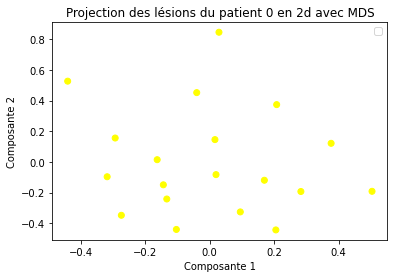

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


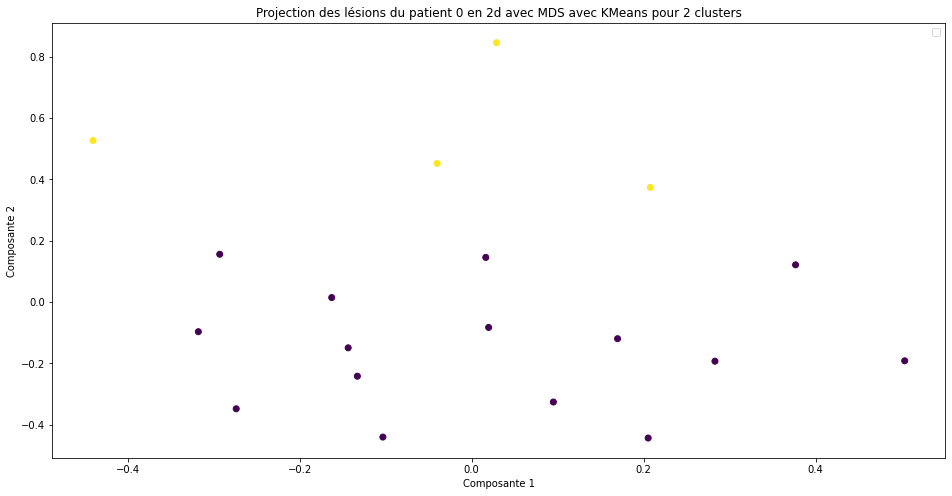

patient_id : 13 index : 15


No handles with labels found to put in legend.


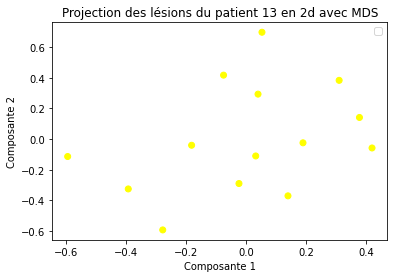

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


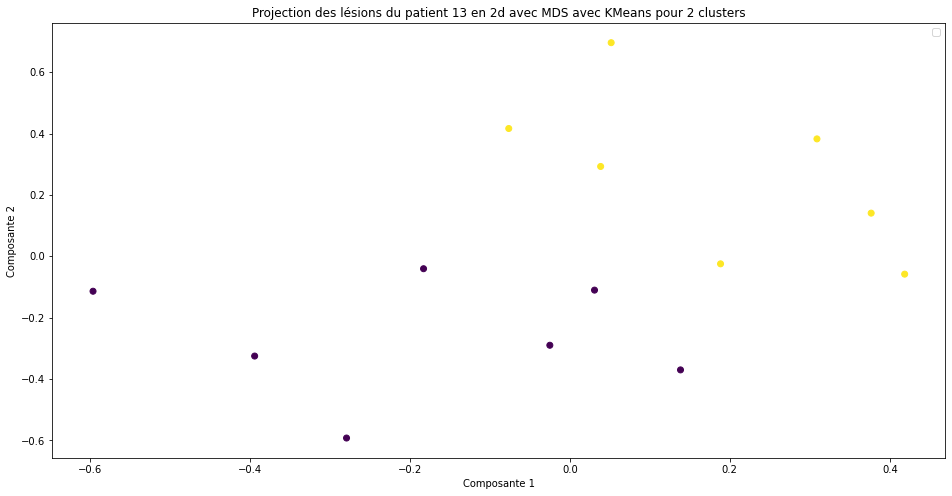

patient_id : 15 index : 26


No handles with labels found to put in legend.


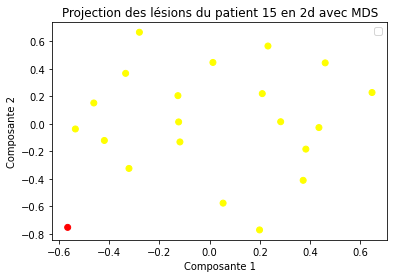

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


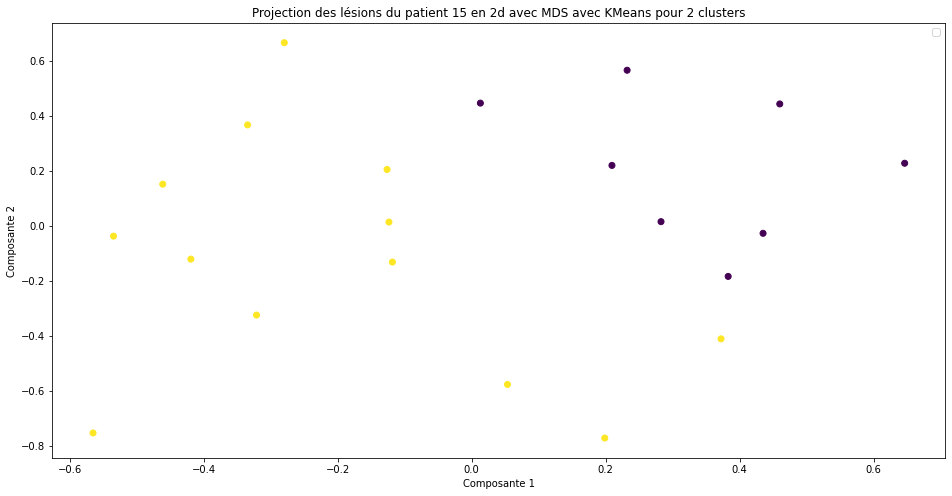

patient_id : 26 index : 34


No handles with labels found to put in legend.


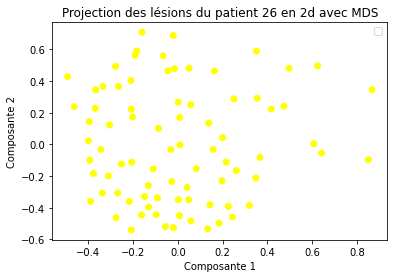

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


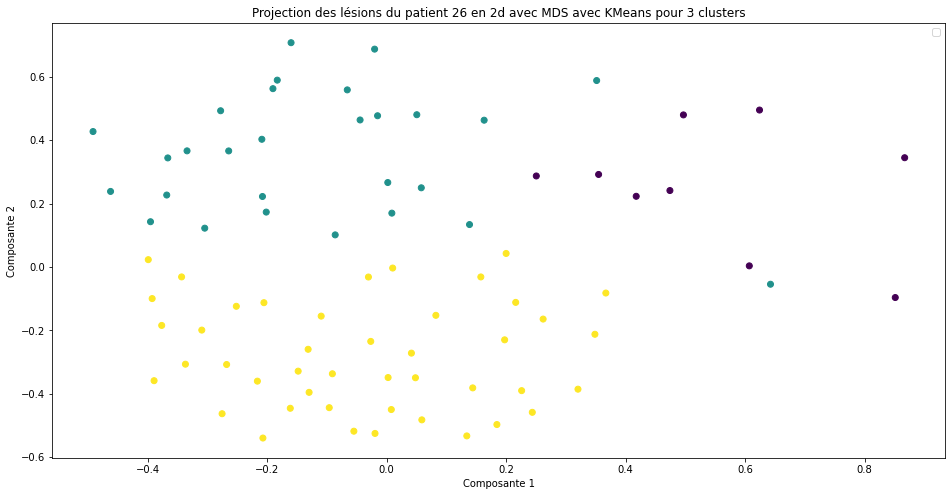

patient_id : 34 index : 41


No handles with labels found to put in legend.


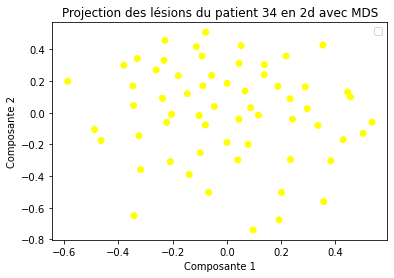

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


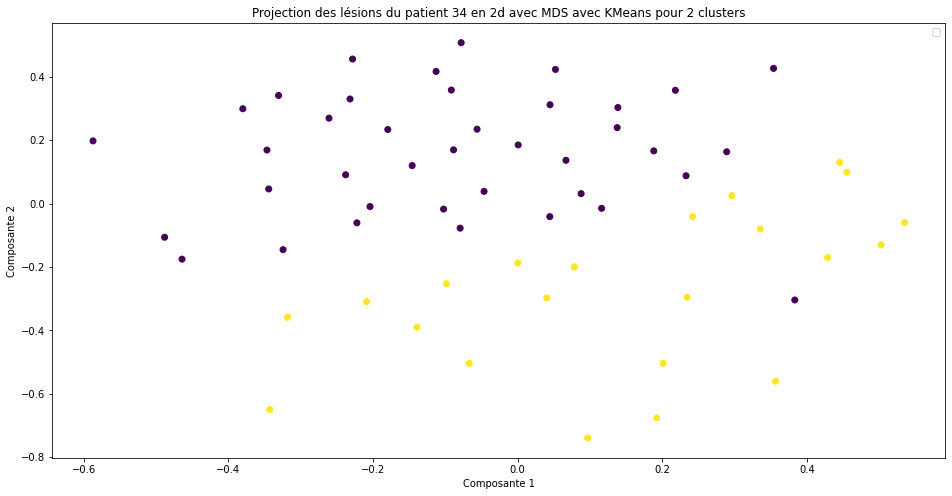

patient_id : 41 index : 49


No handles with labels found to put in legend.


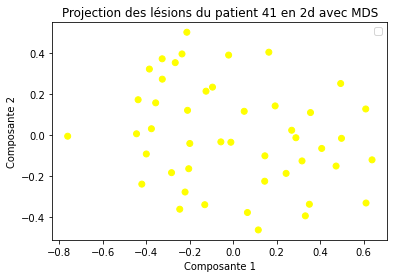

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


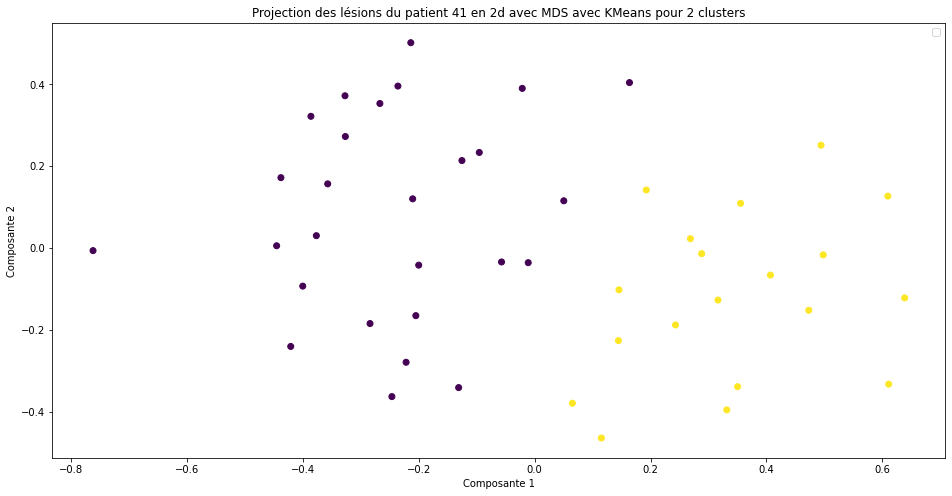

patient_id : 49 index : 51


No handles with labels found to put in legend.


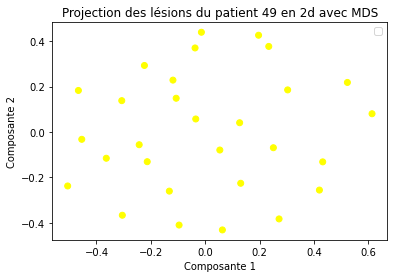

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


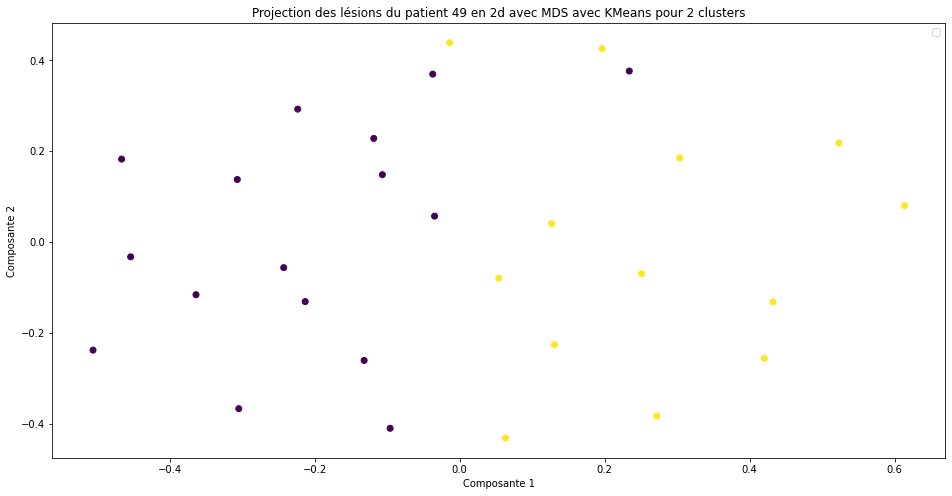

patient_id : 51 index : 60


No handles with labels found to put in legend.


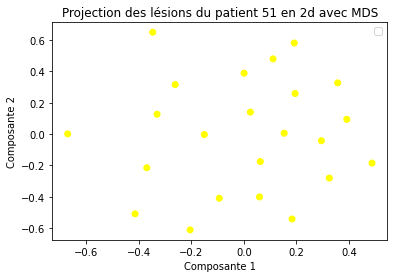

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


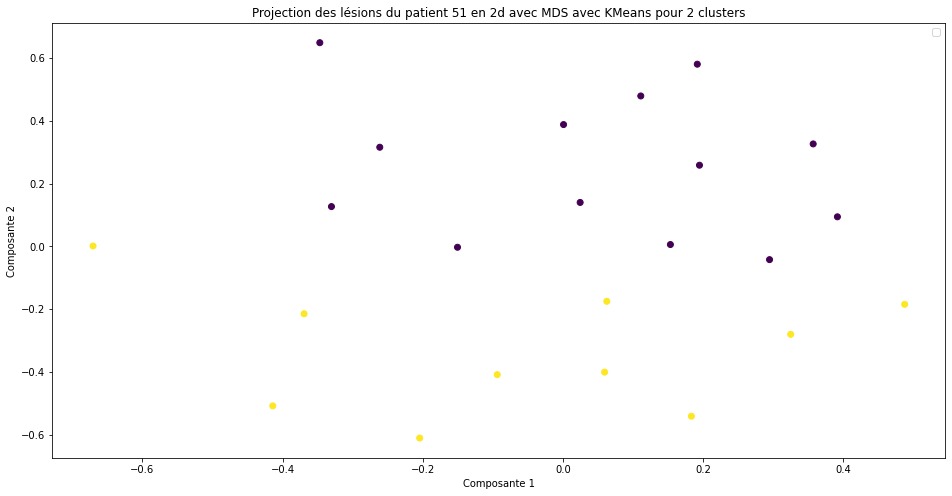

patient_id : 60 index : 65


No handles with labels found to put in legend.


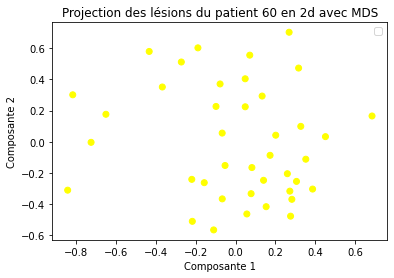

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


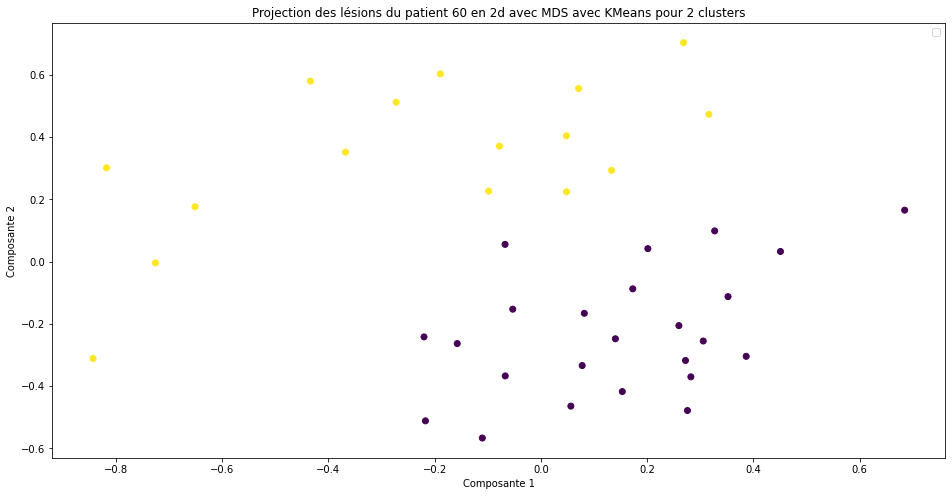

patient_id : 65 index : 68


No handles with labels found to put in legend.


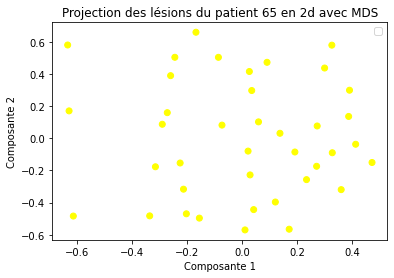

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


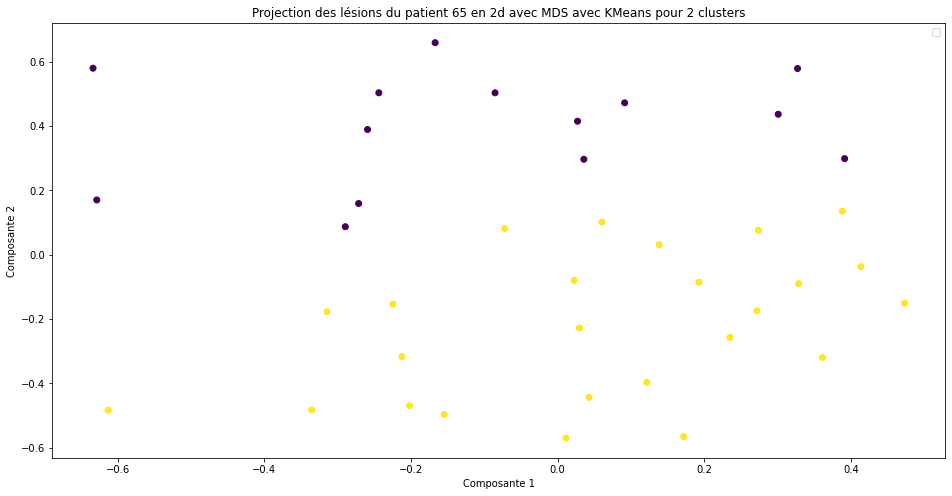

patient_id : 68 index : 126


No handles with labels found to put in legend.


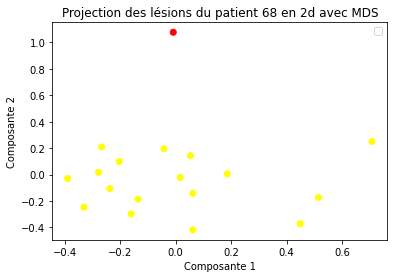

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


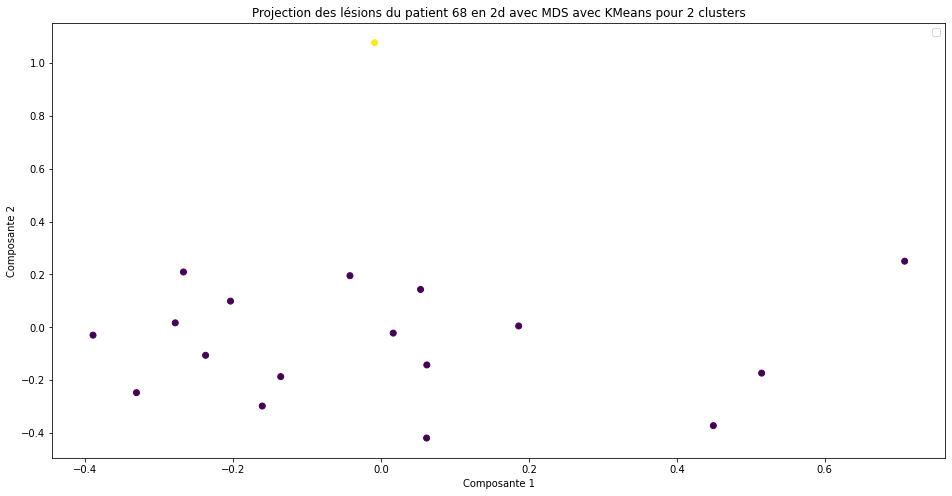

patient_id : 126 index : 127


No handles with labels found to put in legend.


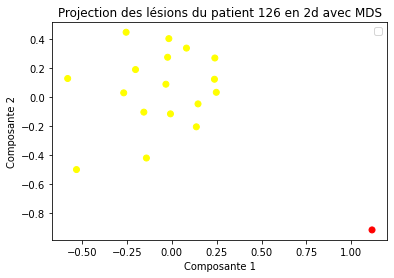

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


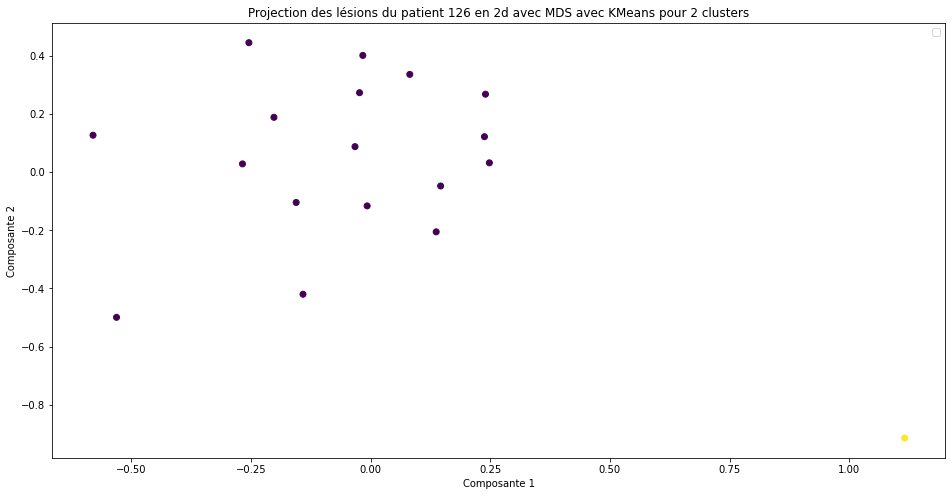

patient_id : 127 index : 133


No handles with labels found to put in legend.


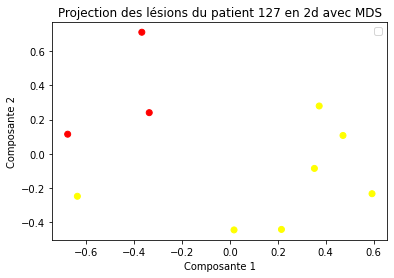

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 3 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 3 dont 0 faux positifs


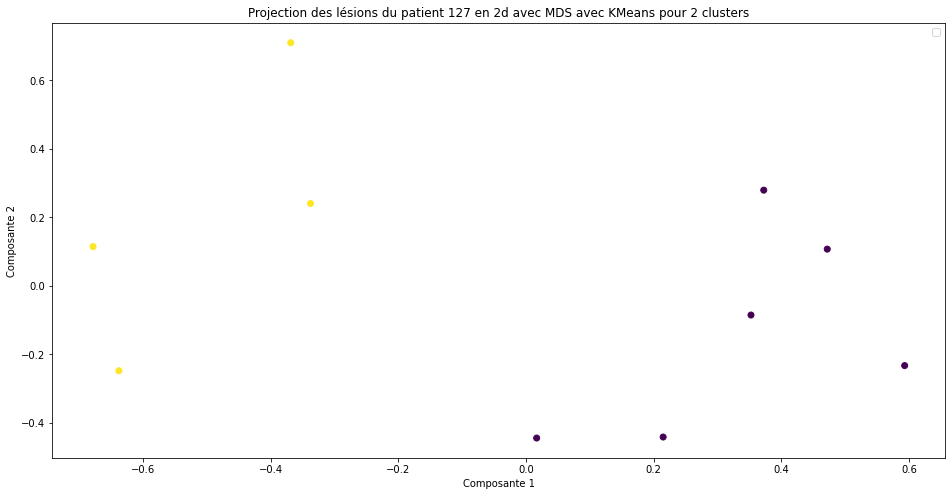

patient_id : 133 index : 150


No handles with labels found to put in legend.


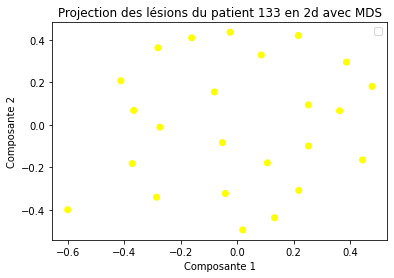

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 1 faux positifs


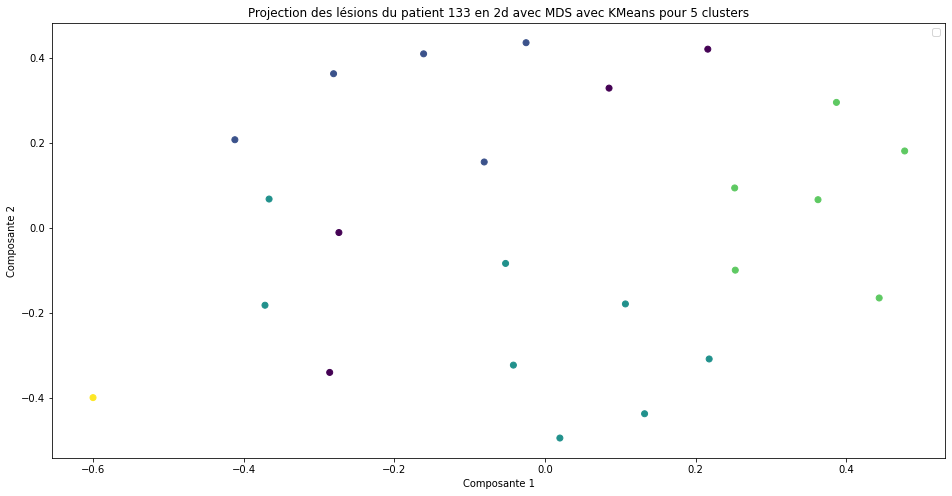

patient_id : 150 index : 165


No handles with labels found to put in legend.


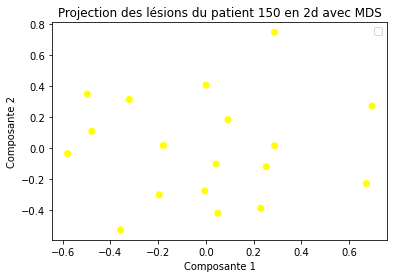

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


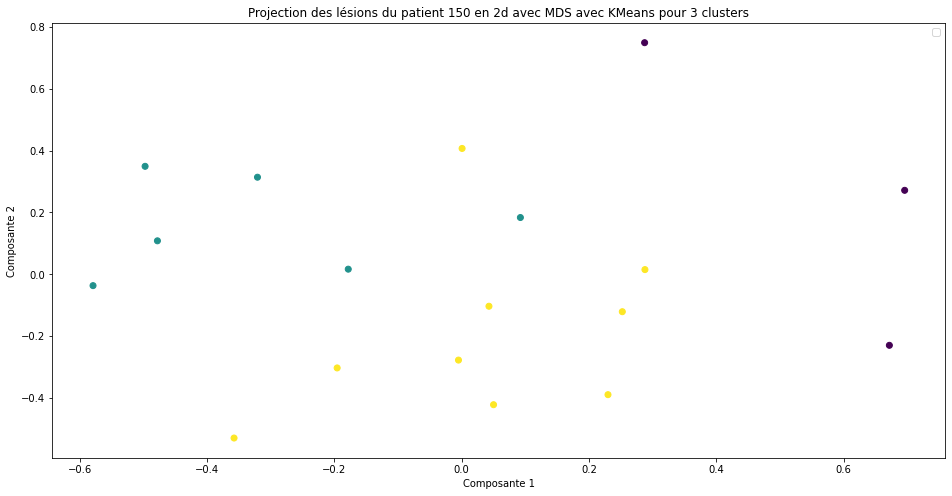

patient_id : 165 index : 176


No handles with labels found to put in legend.


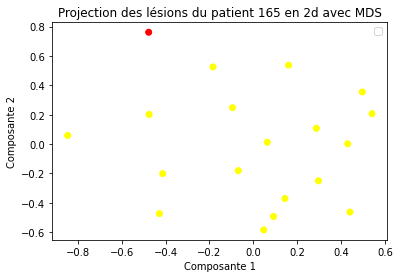

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


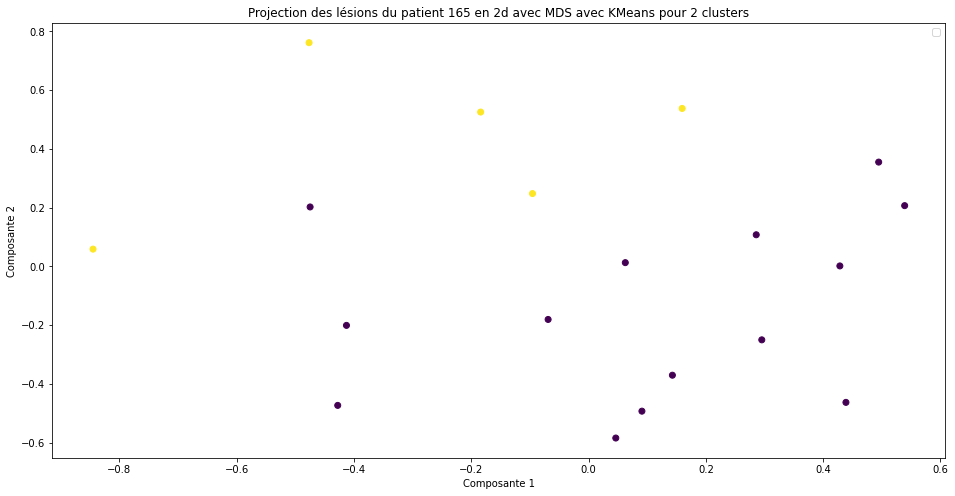

patient_id : 176 index : 186


No handles with labels found to put in legend.


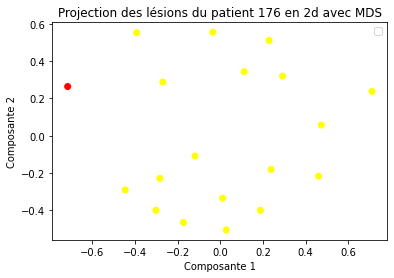

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


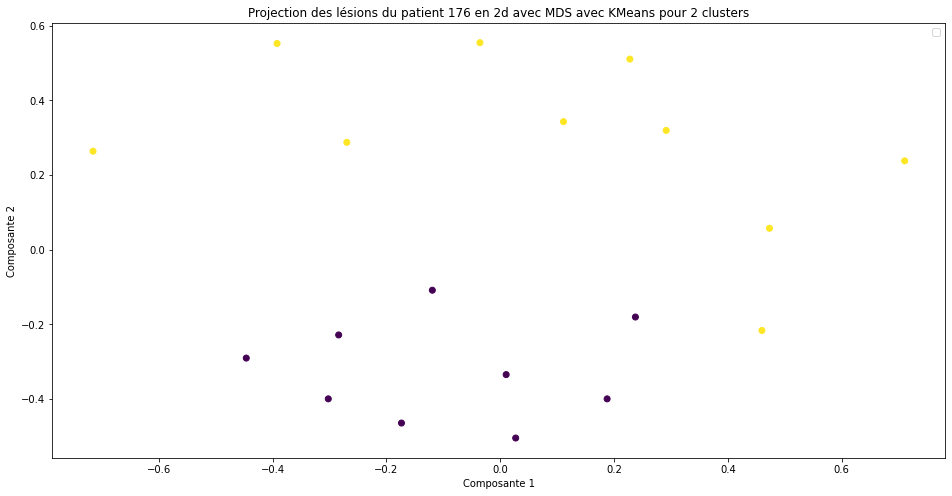

patient_id : 186 index : 197


No handles with labels found to put in legend.


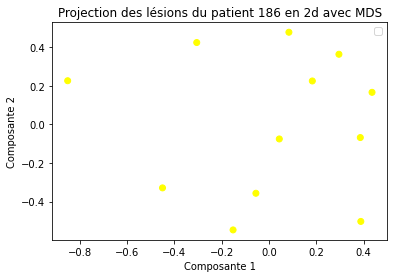

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 0 sur 0 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


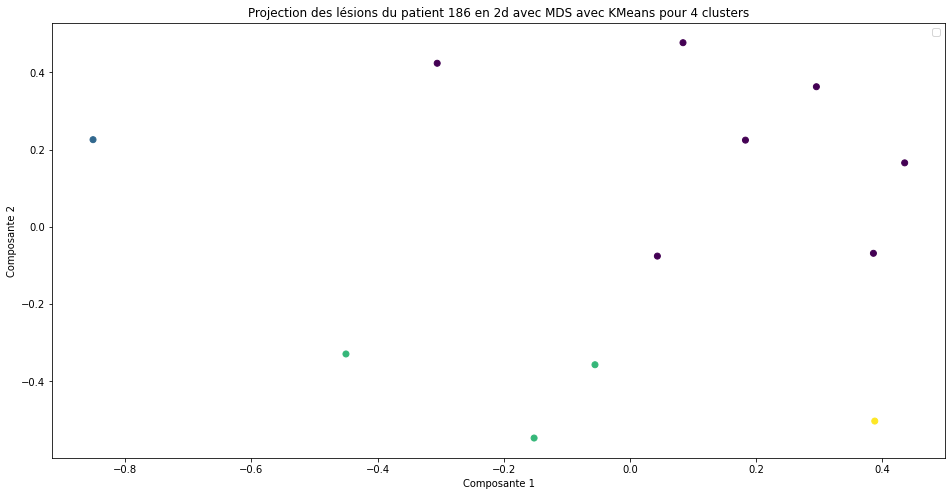

patient_id : 197 index : 203


No handles with labels found to put in legend.


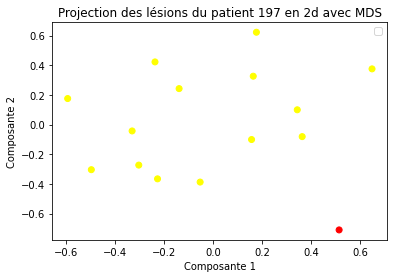

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


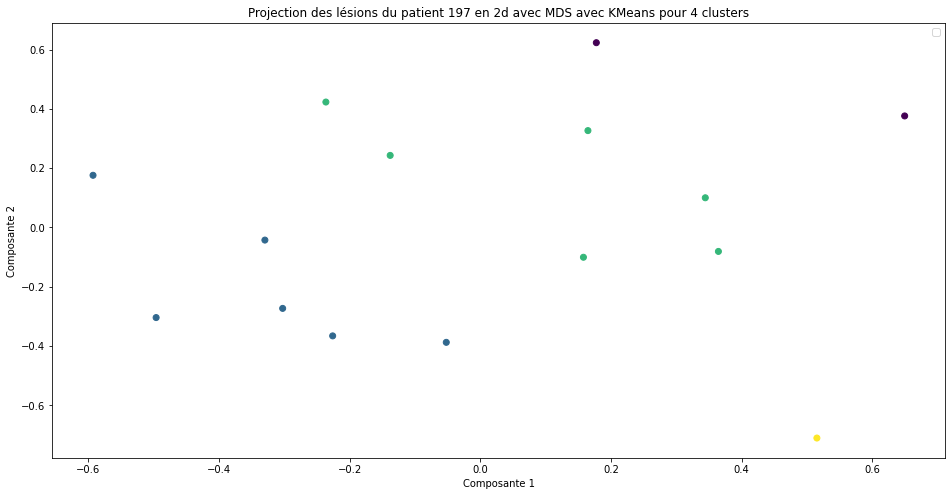

patient_id : 203 index : 206


No handles with labels found to put in legend.


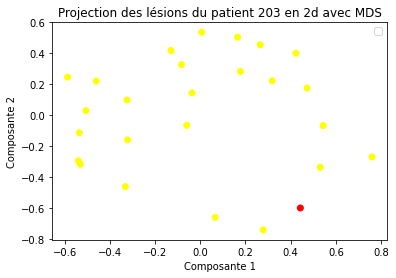

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


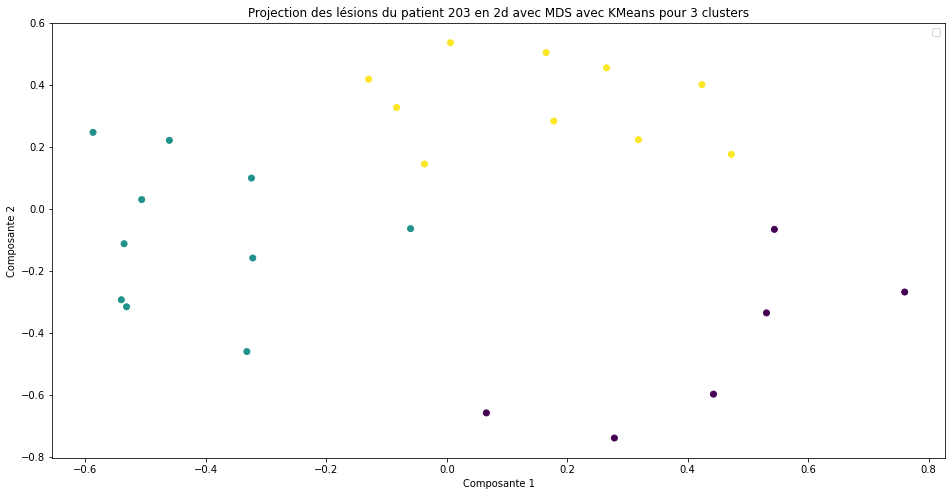

patient_id : 206 index : 209


No handles with labels found to put in legend.


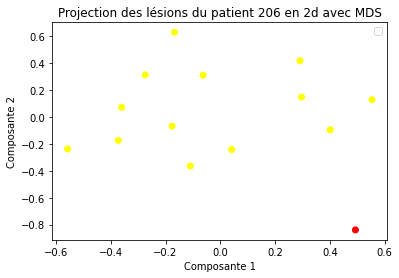

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


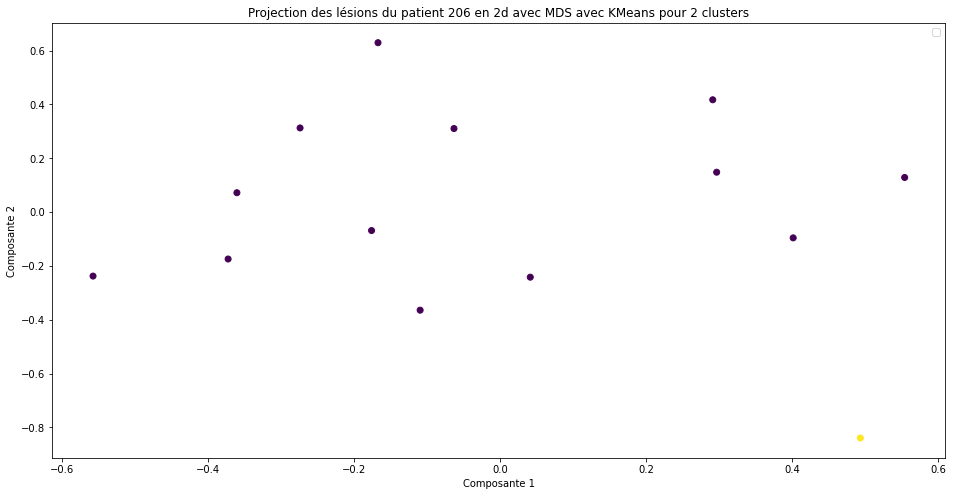

patient_id : 209 index : 211


No handles with labels found to put in legend.


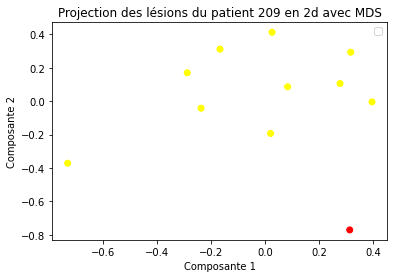

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


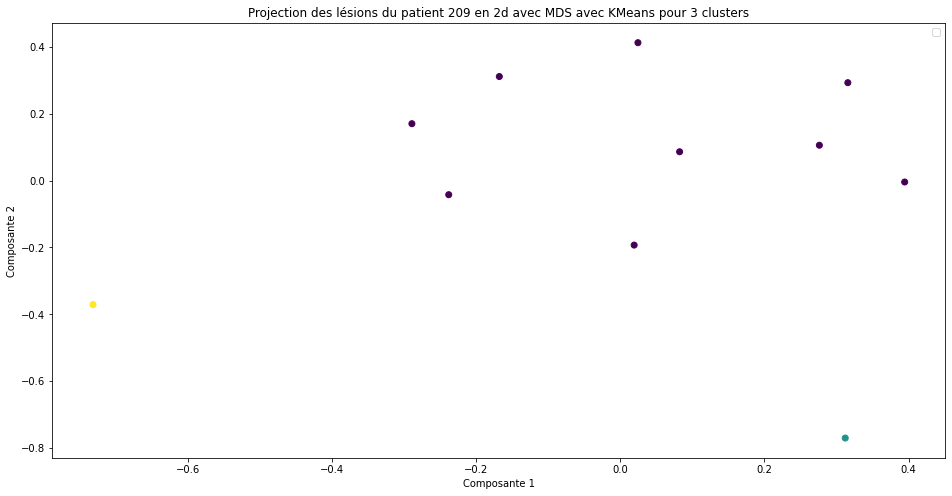

patient_id : 211 index : 215


No handles with labels found to put in legend.


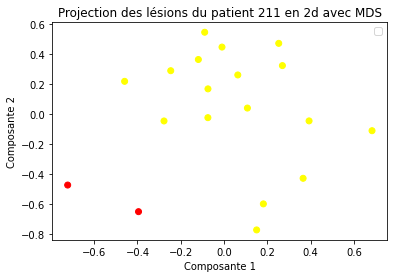

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 2 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 2 VPC sur 2 dont 0 faux positifs


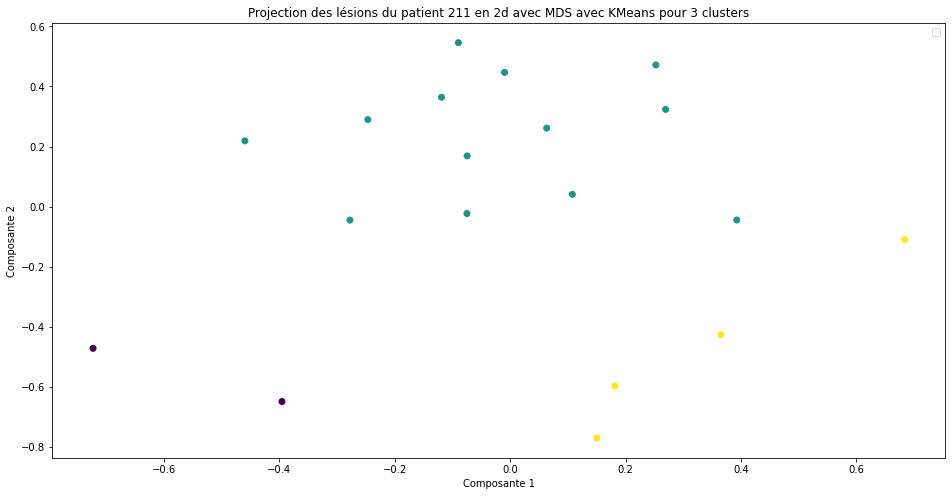

Pour les clusters uniques, rappel : 35.714285714285715 % précision : 55.55555555555556 % et f1 = 43.478260869565226
Pour les clusters uniques + petit cluster , rappel : 50.0 % précision : 53.84615384615385 % et f1 = 51.851851851851855
Pour les clusters uniques + petit cluster , spécificité : 98.96907216494846 % 


In [ ]:
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0 #nombre de lésions prédites comme des VPC dans un cluster unique ou dans des petits clusters
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0 #nombres d'images dans notre dataset
nb_testés_total=0 #initialisation des données statistiques

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv') #on lit notre dataset d'entrainement
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True) #et on l'index par l'identifiant du patient

patient_id=0
for index, row in patients_train_clustering_par_predicteurs.iterrows(): #à chaque ligne
  if patient_id!=index: #lorsqu'on change de patient
    print("patient_id : "+str(patient_id)+" index : "+str(index))
    patient_infos = patients_train_clustering_par_predicteurs.loc[index] #on récupère le patient qui nous interesse
    Y = DataFrame(patient_infos['concensus'], columns = ['concensus']) #on récupère le label de l'image pour faire de la visualisation
    X=patient_infos.drop(['image','concensus'],axis=1) #on récupère les features de notre images
    Y['concensus'][Y['concensus'] == 0] = "red"
    Y['concensus'][Y['concensus'] != "red"] = "yellow"
    y=[]
    for i ,row in Y.iterrows():
      y.append(row[0])  #on créer une liste de couleur ou la couleur rouge décrit les VPC et le jaune les autres 

    nb_images=nb_images+len(y)

    silhouette_vals=[]
    
    nb_cluster_minimum=2
    K = range(nb_cluster_minimum,6) #test de nb_cluster_minimum à 5 clusters
    for o in K:
      clustering = KMeans(n_clusters=o).fit(X)
      labels = clustering.labels_
      silhouette_vals.append(np.mean(silhouette_score(X,labels))) #pour un certains nombre de clusters on calcule la silhouette de notre clustering

    mds = manifold.MDS(n_components=2)
    mds.fit(X)
    projectedMDS = mds.fit_transform(X)
    plt.scatter(projectedMDS[:, 0], projectedMDS[:, 1], c=y)
    plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec MDS")
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.legend()
    plt.show() #on visualise les lésions cutanées du patient avec mds, les VPC y sont situés en rouge 

    idx_max=0
    max=-1
    for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette - nb_cluster_minimum
      if silhouette_vals[k]>max:
        max=silhouette_vals[k]
        idx_max=k

    clustering = KMeans(n_clusters=idx_max+nb_cluster_minimum)    #l'on utilise le nombre de clusters maximisant la silhouette
    prediction = clustering.fit_predict(X)

    #comparaison entre le vrai clustering et la prediction au niveau des VPC
    #premièrement on regarde le nombre de VPC repérés dans des clusters uniques

    index_VPC=[] #dans cette liste apparaitront les index des VPC
    nb_testés=0 #nombre de lésions prédites comme des VPC dans un cluster unique
    nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction

    liste_clusters=[] #dans cette liste apparaitront les index des images par cluster pour les repérer plus facilement an allant regarder nos images
    for e in range(nb_clusters):
      liste_clusters.append([])

    for a in range(len(y)):
      if y[a]=="red":
        index_VPC.append(a) #index des VPC
      liste_clusters[prediction[a]].append(a)
    
    clusters_unique=[]
    for g in range (nb_clusters):
      if len(liste_clusters[g])==1:
        nb_testés=nb_testés+1
        nb_testés_total=nb_testés_total+1
        clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
    nb_trouvés_unique=0
    for l in index_VPC:
      if l in clusters_unique:
        nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
    nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique #nombre total de VPC trouvés par clusters contenant un seul individu
    nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique #nombres total d'images apparaissant dans des clusters uniques sans être un VPC
  
    print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

    #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

    nb_VPC_total = nb_VPC_total + len(index_VPC)

    nb_trouvés_petit_cluster=0
    nb_cas_petit_cluster=0 #le nombre d'images que l'on va tester en regardant les petit clusters
    liste_index_petit_clusters=[]
    nb_individus_max=2

    for r in range(len(liste_clusters)):
      if 1<len(liste_clusters[r])<=nb_individus_max: #pour les clusters allant jusqu'à nb_individus_max individus on regarde s'il s'y trouve des VPC
        nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r]) 
        nb_testés=nb_testés+len(liste_clusters[r]) #le nombre d'images testés augmente et permet de voir les nombre de faux positifs pour un patient
        nb_testés_total=nb_testés_total+len(liste_clusters[r])
        liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
    for g in liste_index_petit_clusters:
      for h in liste_clusters[g]:
        if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
          nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

    nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster #le nombre de faux positifs trouvés dans les petits clusters se voit augmenter 
    nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster #le nombre de vrai positif dans les clusters uniques et petits clusters

    print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

    plt.figure(figsize=(16,8))
    plt.scatter(projectedMDS[: , 0] , projectedMDS[: , 1] , c = prediction)
    plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec MDS avec KMeans pour "+str(idx_max+2)+" clusters")
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.legend()
    plt.show() #cette fois on affiche la prediction du kmeans ayant le meilleur score en silhouette 

  patient_id=index #on change de patient
  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn = nb_VPC_total- vp
vn= nb_images -fp-vp-fn

print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")




## Clustering par agglomération

Le clustering agglomératif est le type le plus courant de clustering hiérarchique utilisé pour regrouper des objets en clusters en fonction de leur similitude. Il est également connu sous le nom de AGNES (Agglomerative Nesting).

L'algorithme commence par traiter chaque objet comme un cluster singleton. Ensuite, les paires de clusters sont fusionnées successivement jusqu'à ce que tous les clusters aient été fusionnés en un seul grand cluster contenant tous les objets. Le résultat est une représentation arborescente des objets, nommée dendrogramme.

explication du paramètre linkage : https://machinelearninggeek.com/agglomerative-clustering/

No handles with labels found to put in legend.


patient_id : 0 index : 13


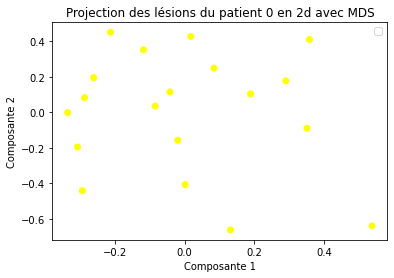

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 6 faux positifs
la liste des clusters est : [[6, 14], [1, 2, 3, 4, 5, 8, 9, 10, 12, 13, 15, 17, 18], [0, 7, 11, 16]]
les index des VPC sont : []


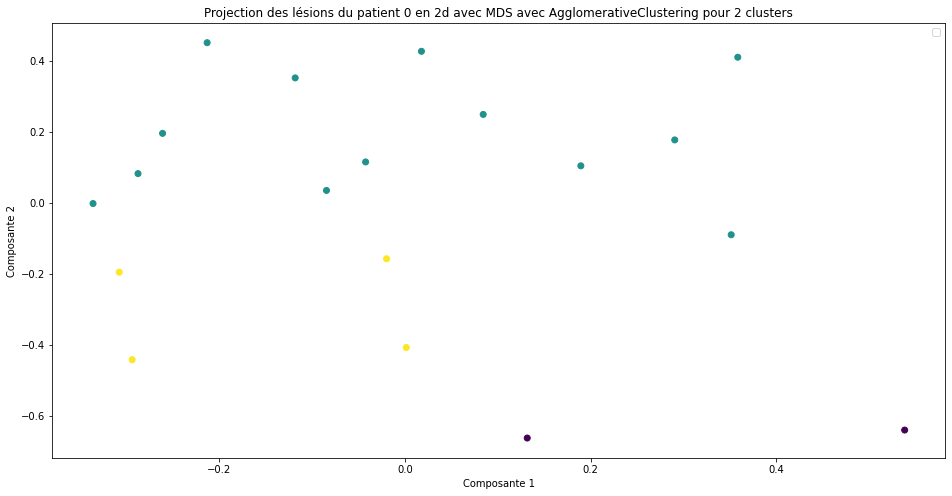

No handles with labels found to put in legend.


patient_id : 13 index : 15


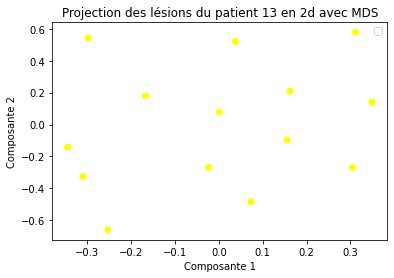

Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs
la liste des clusters est : [[0, 2, 10, 11, 12, 13], [5, 8, 9], [1, 3, 4, 6, 7]]
les index des VPC sont : []


No handles with labels found to put in legend.


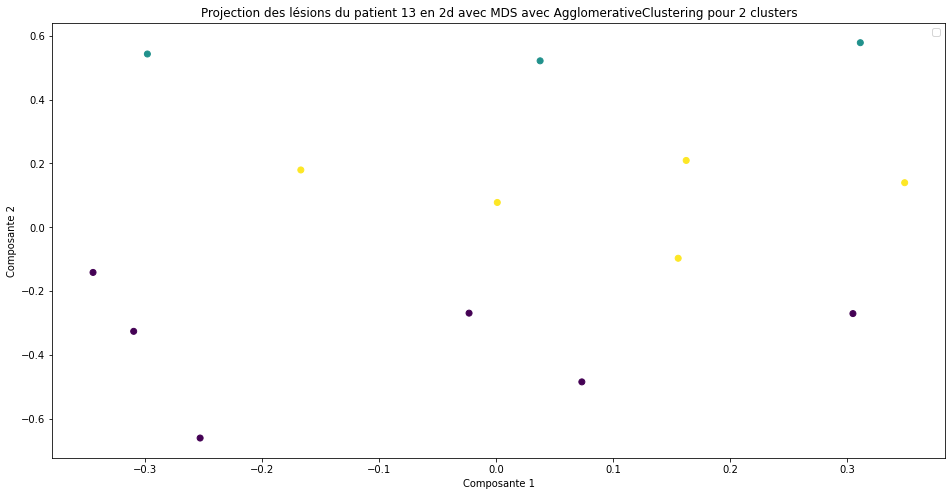

patient_id : 15 index : 26


No handles with labels found to put in legend.


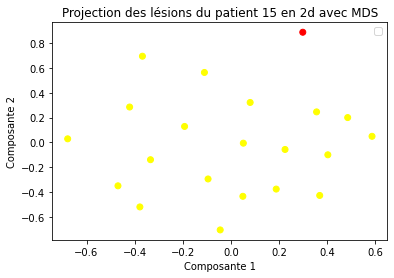

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 3 faux positifs
la liste des clusters est : [[0, 3, 4, 5, 8, 13, 14, 15], [1, 2, 7], [6, 9, 10, 11, 12, 17, 18, 19, 20], [16]]
les index des VPC sont : [16]


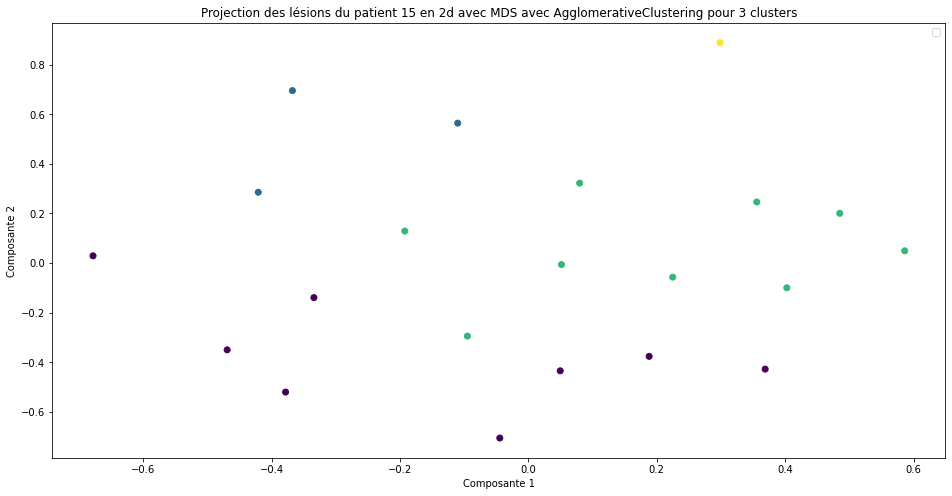

patient_id : 26 index : 34


No handles with labels found to put in legend.


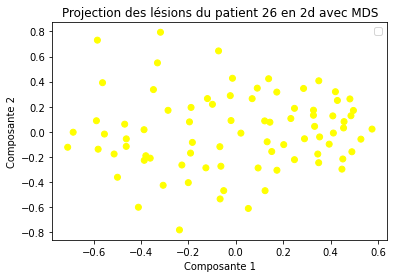

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs
la liste des clusters est : [[1, 25, 26, 27, 59, 61, 64, 70], [0, 4, 5, 6, 9, 11, 12, 13, 16, 22, 32, 34, 46, 47, 50, 51, 66, 80], [2, 3, 7, 10, 15, 17, 19, 38, 53, 55, 56, 60, 65], [8, 20, 21, 24, 28, 29, 30, 31, 33, 35, 36, 37, 39, 41, 43, 44, 45, 49, 52, 57, 62, 63, 67, 68, 72, 75, 76, 77, 78], [14, 18, 23, 40, 42, 48, 54, 58, 69, 71, 73, 74, 79]]
les index des VPC sont : []


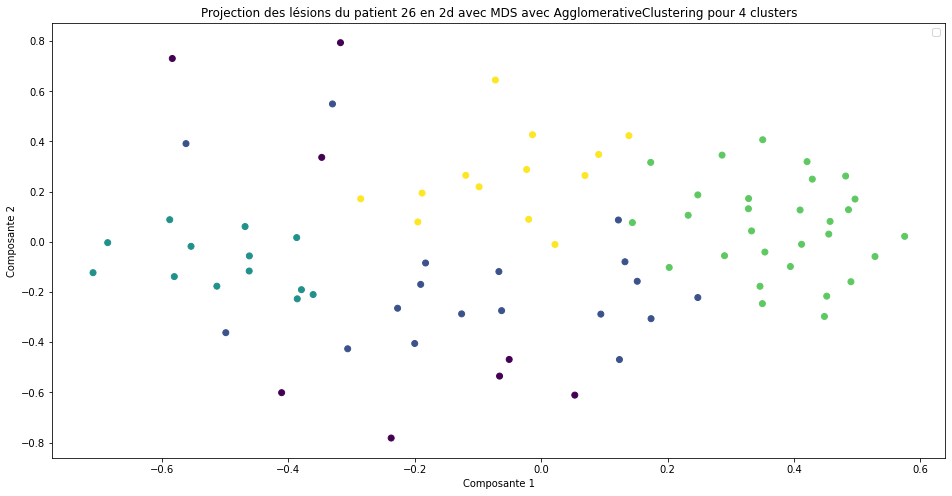

patient_id : 34 index : 41


No handles with labels found to put in legend.


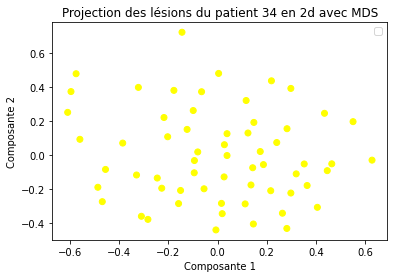

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs
la liste des clusters est : [[3, 6, 7, 8, 9, 10, 11, 12, 15, 17, 18, 19, 21, 22, 25, 26, 27, 28, 33, 34, 36, 37, 39, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 58, 59, 60], [0, 4, 5, 13, 16, 24, 29, 30, 35, 40, 41, 48, 50, 52, 57], [1, 2, 14, 20, 23, 31, 32, 38]]
les index des VPC sont : []


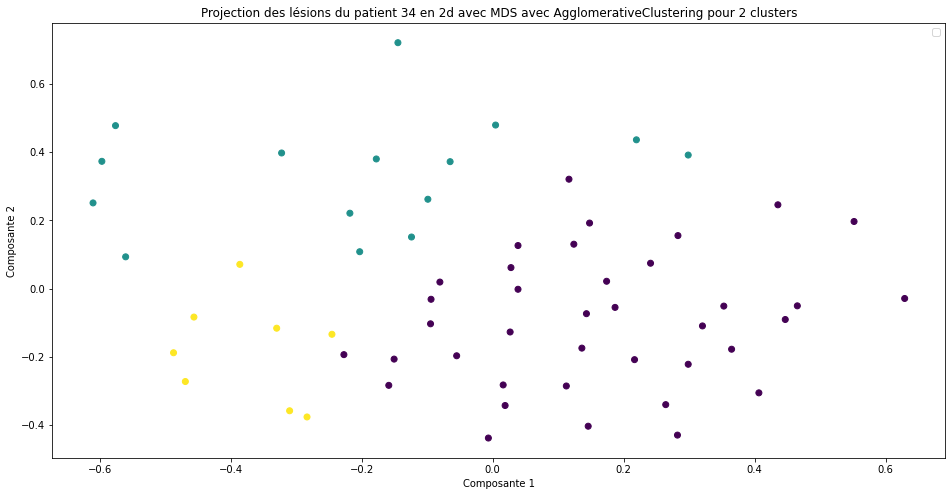

patient_id : 41 index : 49


No handles with labels found to put in legend.


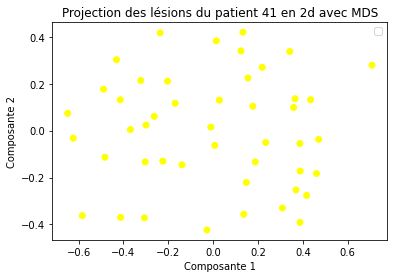

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs
la liste des clusters est : [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 17, 19, 25, 44, 45], [21, 22, 23, 24, 28, 33, 34, 35, 36, 38, 41, 42, 43], [10, 13, 14, 18, 20, 26, 27, 29, 30, 31, 32, 37, 39, 40]]
les index des VPC sont : []


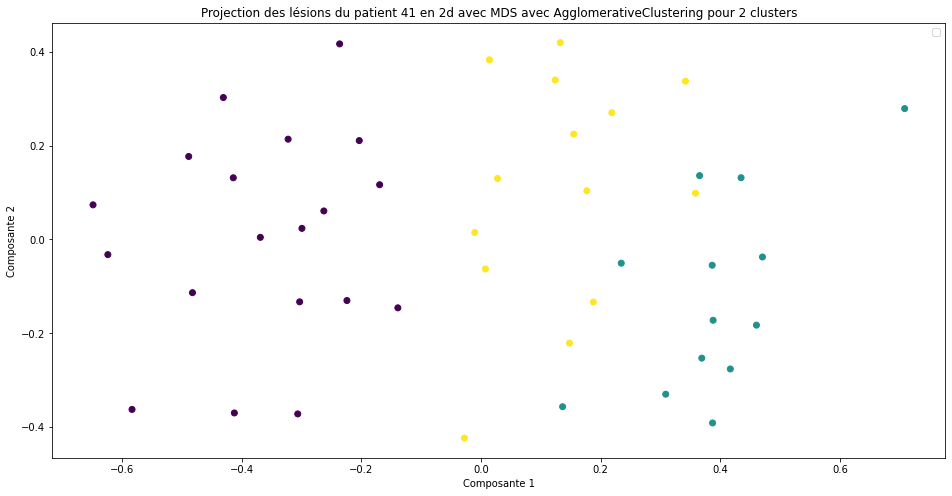

patient_id : 49 index : 51


No handles with labels found to put in legend.


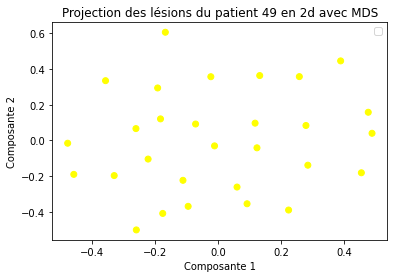

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs
la liste des clusters est : [[1, 2, 4, 7, 9, 11, 12, 13, 17, 20, 22, 26], [0, 3, 5, 6, 10, 15, 16, 18, 19], [8, 14, 21, 23, 24, 25, 27, 28]]
les index des VPC sont : []


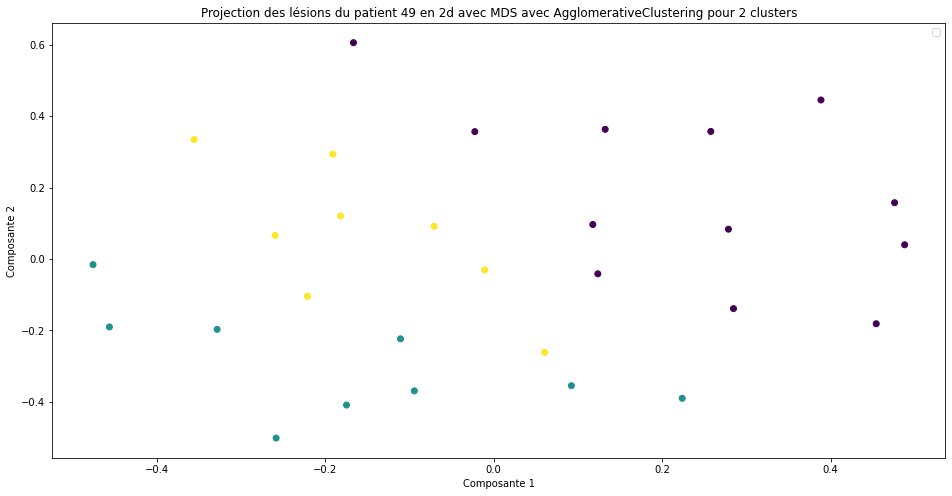

patient_id : 51 index : 60


No handles with labels found to put in legend.


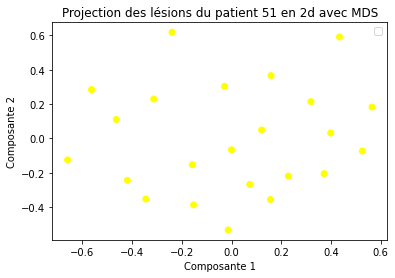

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 8 faux positifs
la liste des clusters est : [[2, 9, 10, 12, 17, 18, 20], [4, 6, 19, 22], [0, 1, 3, 5, 7, 13, 15, 16], [8, 11, 14], [21]]
les index des VPC sont : []


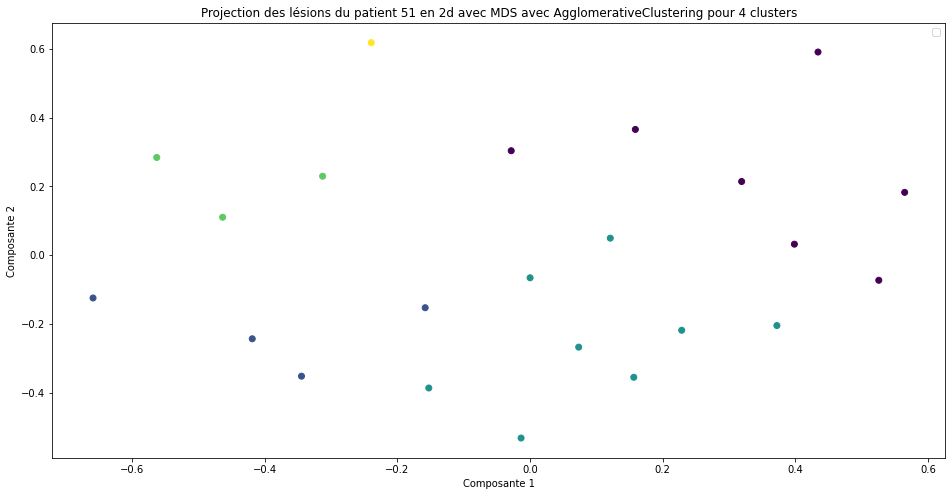

patient_id : 60 index : 65


No handles with labels found to put in legend.


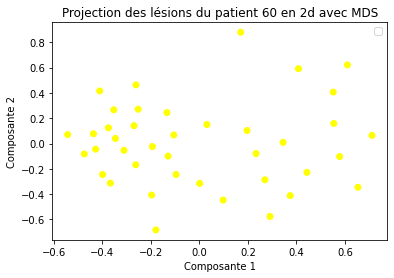

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 4 faux positifs
la liste des clusters est : [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39], [10, 17, 18, 19, 22, 23, 28, 29, 30, 31], [14, 16, 20, 21]]
les index des VPC sont : []


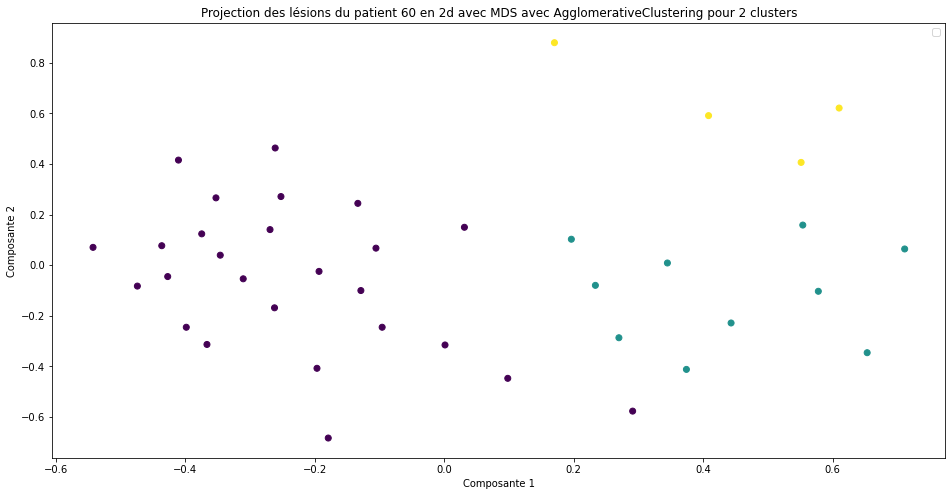

patient_id : 65 index : 68


No handles with labels found to put in legend.


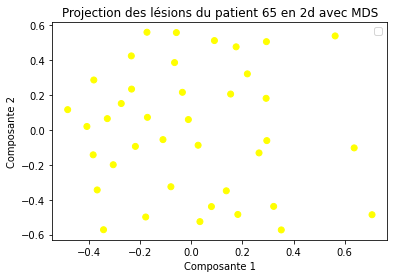

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs
la liste des clusters est : [[0, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 25, 27, 28, 30, 32, 33, 34, 38], [1, 2, 3, 4, 13, 24, 26, 31, 35, 36, 37], [5, 6, 7, 8, 9, 17, 22, 29]]
les index des VPC sont : []


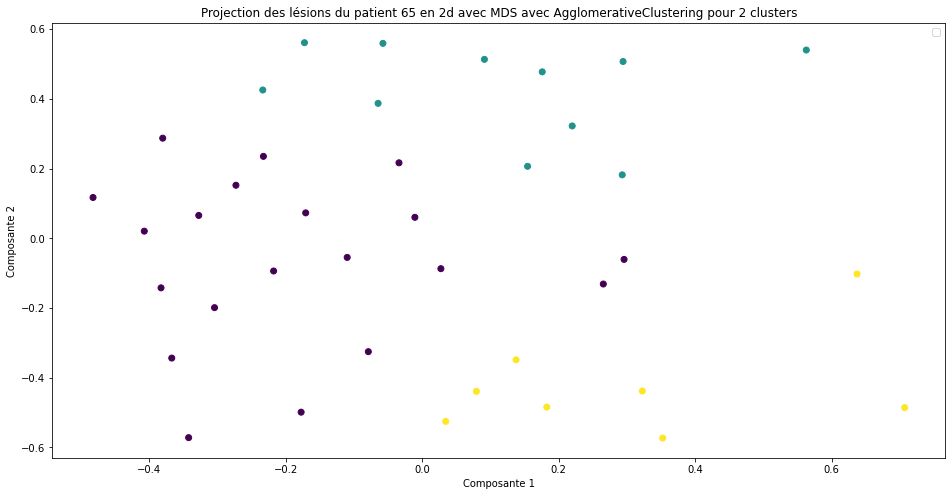

patient_id : 68 index : 126


No handles with labels found to put in legend.


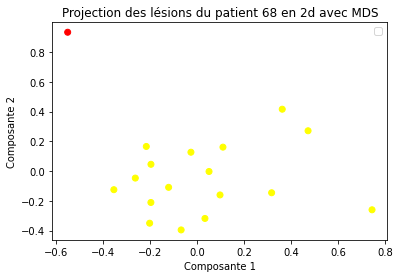

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 3 faux positifs
la liste des clusters est : [[13, 15, 17], [0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16]]
les index des VPC sont : [0]


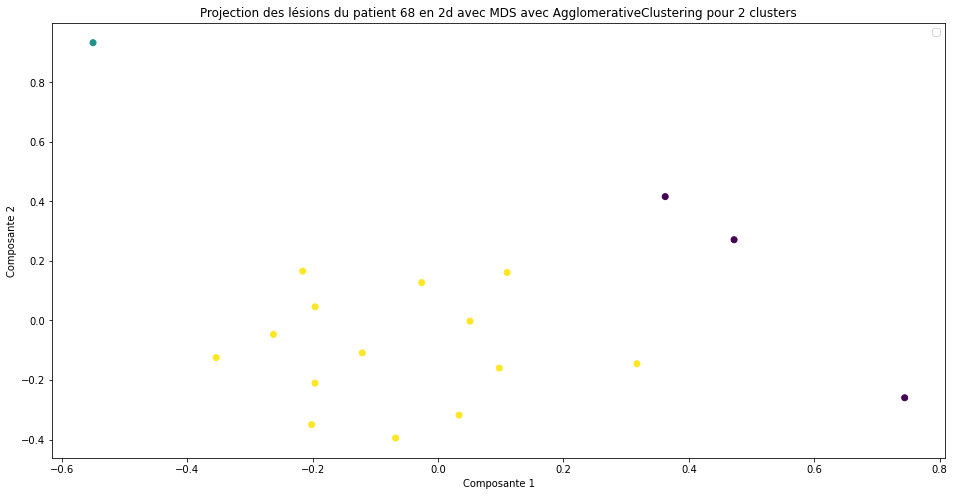

No handles with labels found to put in legend.


patient_id : 126 index : 127


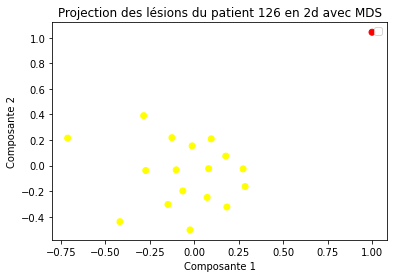

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs
la liste des clusters est : [[1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17], [0], [8, 11]]
les index des VPC sont : [0]


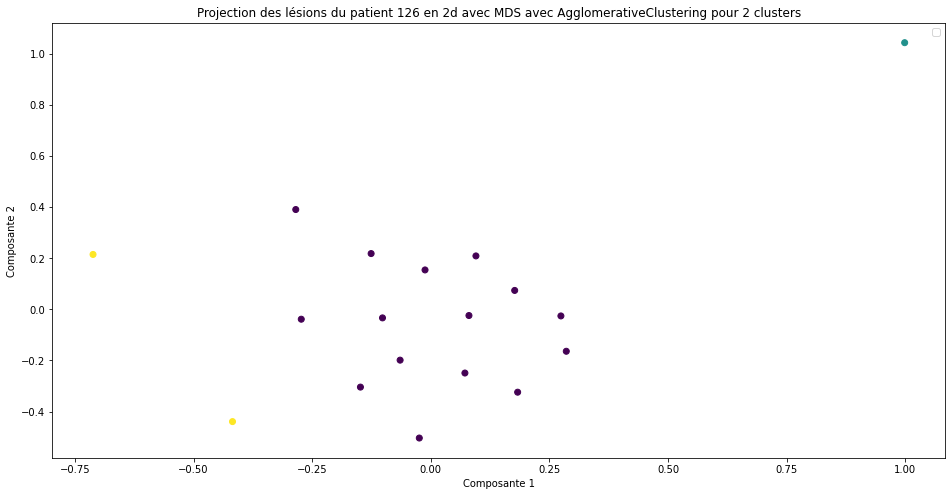

No handles with labels found to put in legend.


patient_id : 127 index : 133


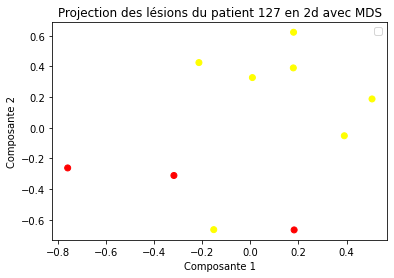

Le clustering unique trouve 1 unique dont 1 sur 3 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 3 VPC sur 3 dont 1 faux positifs
la liste des clusters est : [[3, 4, 5, 6, 8, 9], [0, 2, 7], [1]]
les index des VPC sont : [0, 1, 2]


No handles with labels found to put in legend.


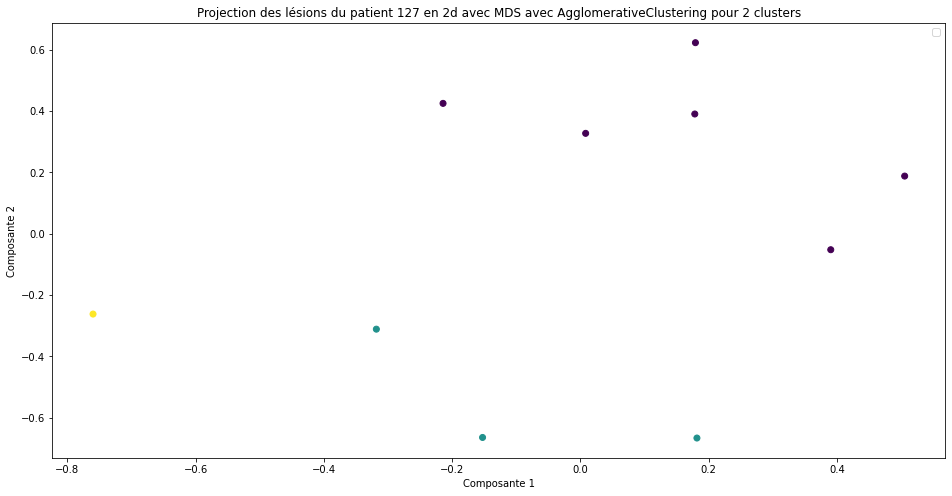

patient_id : 133 index : 150


No handles with labels found to put in legend.


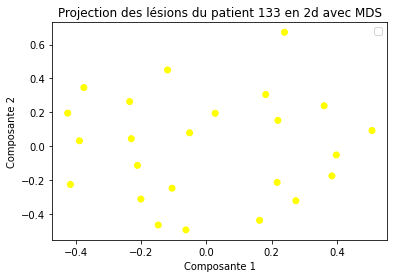

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 9 faux positifs
la liste des clusters est : [[0, 1, 2, 5, 8, 11, 15, 16, 23], [3, 17, 18, 19, 20, 22], [4, 7, 9, 10], [21], [6, 12, 13, 14]]
les index des VPC sont : []


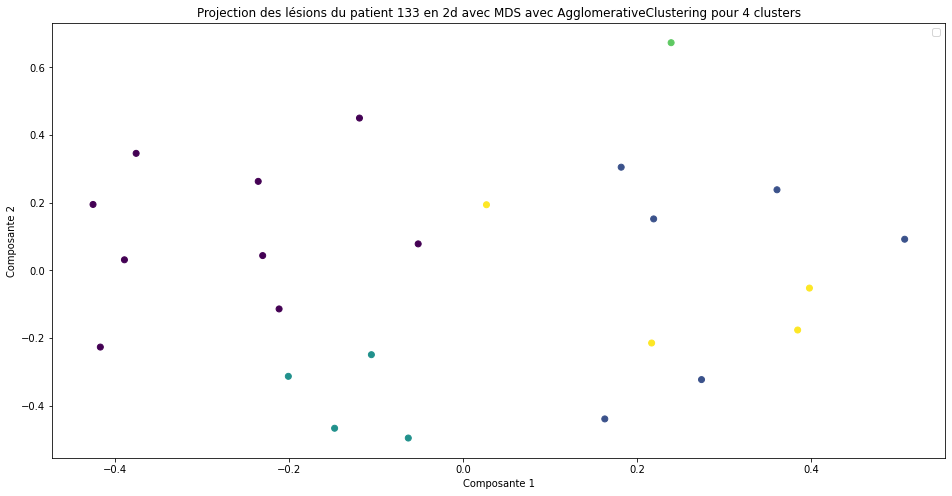

patient_id : 150 index : 165


No handles with labels found to put in legend.


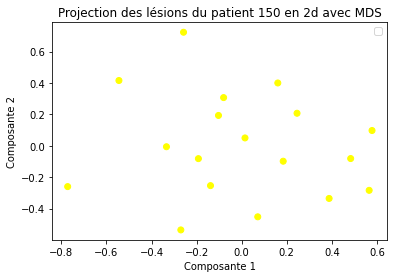

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 7 faux positifs
la liste des clusters est : [[0, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16], [2, 3, 9, 12], [13, 17], [1]]
les index des VPC sont : []


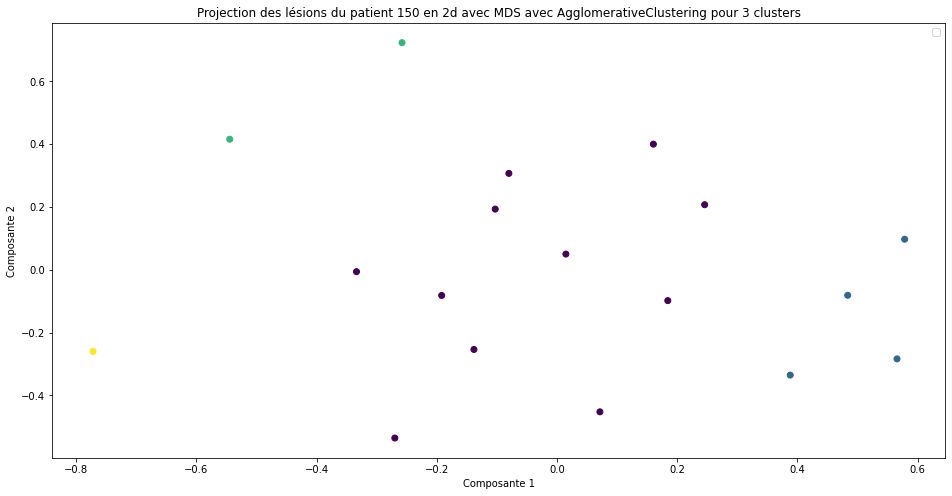

patient_id : 165 index : 176


No handles with labels found to put in legend.


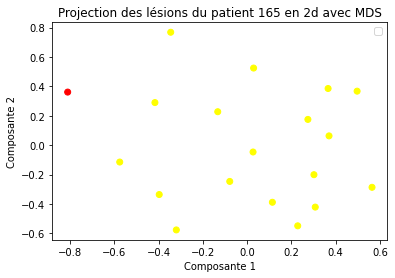

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 3 faux positifs
la liste des clusters est : [[4, 5, 6, 7, 8, 9, 11, 12, 14, 17, 18], [0, 2, 3, 15, 16], [1, 10, 13]]
les index des VPC sont : [0]


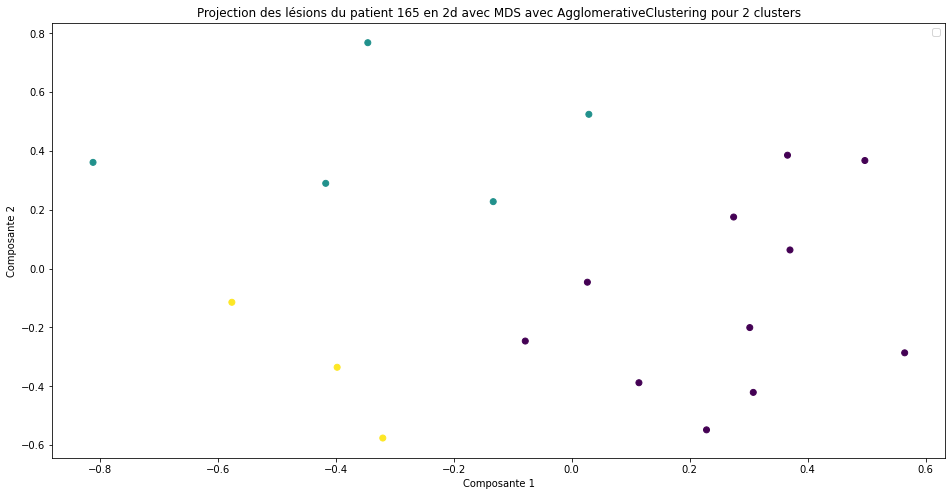

patient_id : 176 index : 186


No handles with labels found to put in legend.


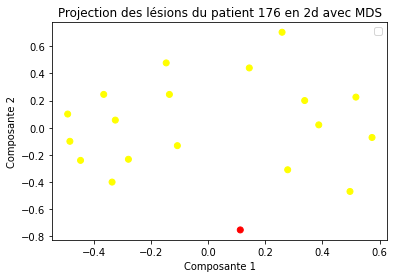

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 4 faux positifs
la liste des clusters est : [[2, 4, 5, 9, 12, 13], [1, 3, 6, 7, 8, 16, 17, 18], [10, 11, 14, 15], [0]]
les index des VPC sont : [0]


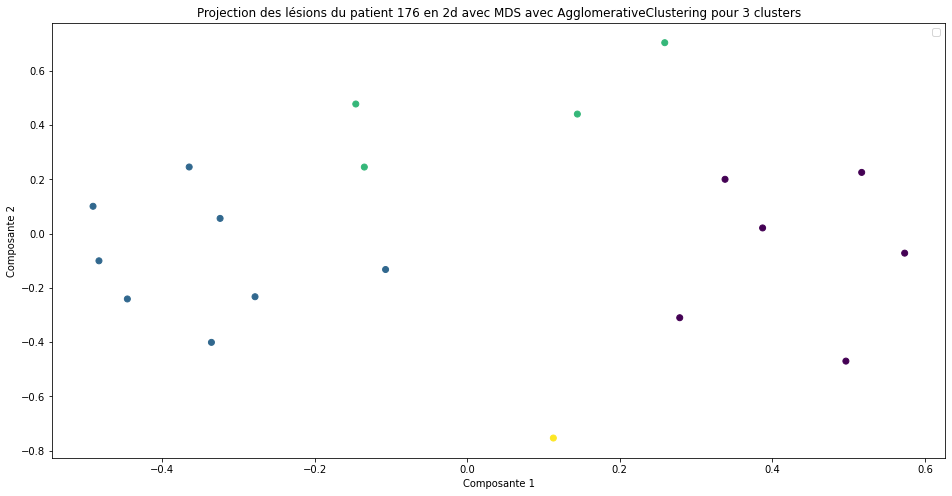

No handles with labels found to put in legend.


patient_id : 186 index : 197


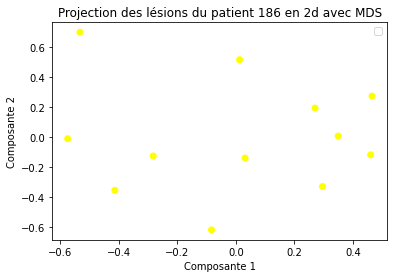

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 6 faux positifs
la liste des clusters est : [[0, 7], [1, 4, 5, 6, 10, 11], [3, 8, 9], [2]]
les index des VPC sont : []


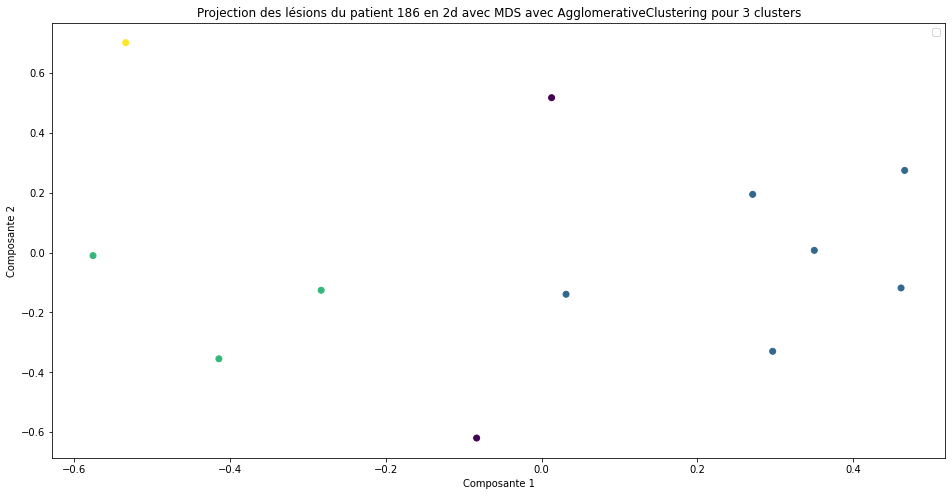

No handles with labels found to put in legend.


patient_id : 197 index : 203


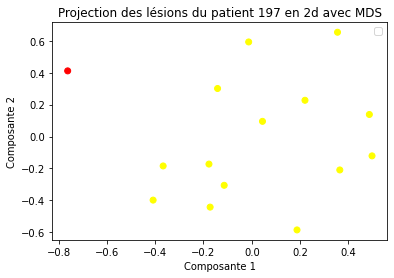

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs
la liste des clusters est : [[7, 9, 10, 12, 13, 14], [2, 4, 5, 6, 8, 11], [0], [1, 3]]
les index des VPC sont : [0]


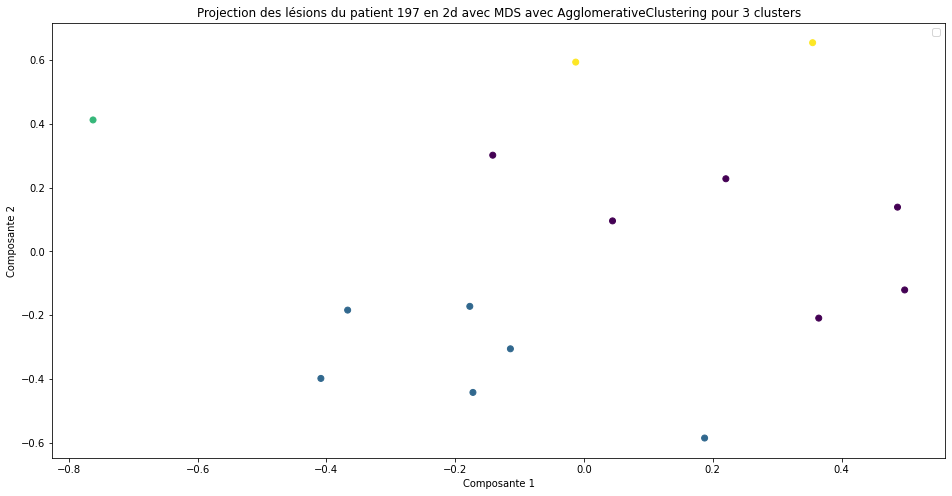

patient_id : 203 index : 206


No handles with labels found to put in legend.


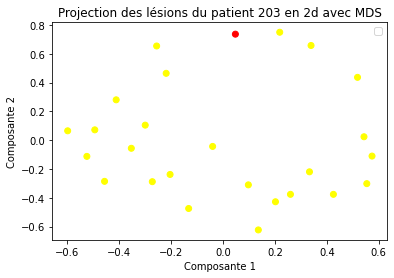

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs
la liste des clusters est : [[9, 10, 11, 18, 22, 23, 25], [0, 1, 6, 7, 8, 12, 14, 17, 21, 24], [2, 3, 4, 5, 13, 15, 16, 19, 20]]
les index des VPC sont : [18]


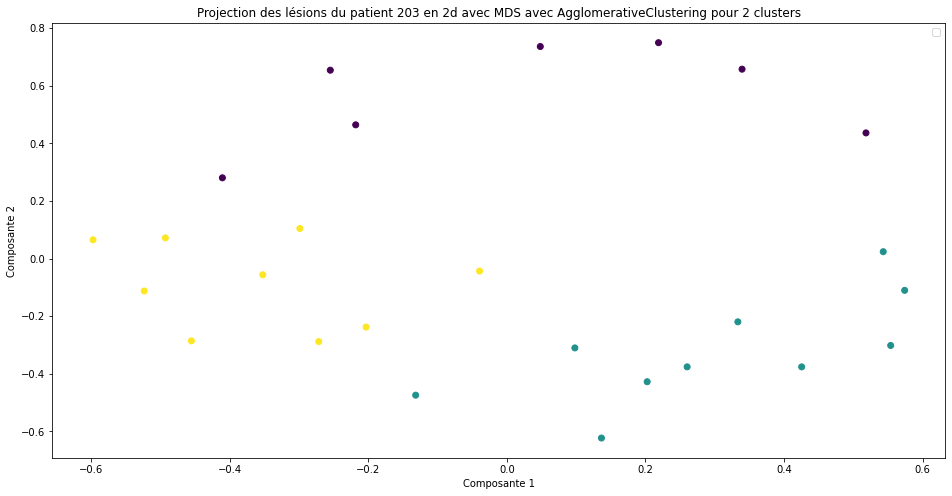

No handles with labels found to put in legend.


patient_id : 206 index : 209


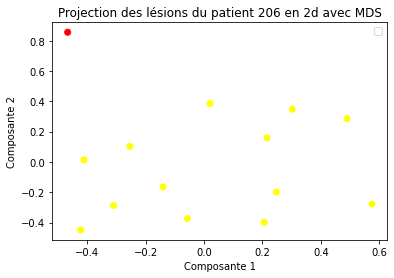

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 4 faux positifs
la liste des clusters est : [[0, 1, 2, 3, 4, 6, 9, 10, 11], [8], [5, 7, 12, 13]]
les index des VPC sont : [8]


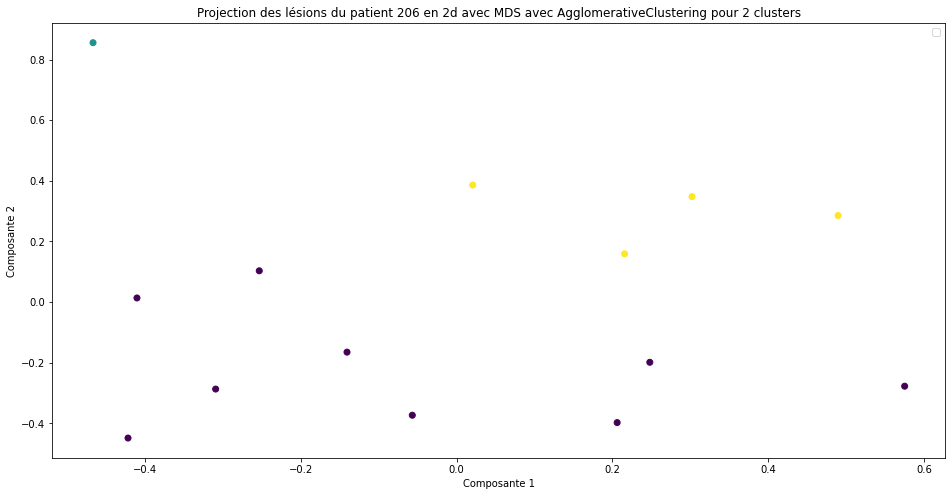

No handles with labels found to put in legend.


patient_id : 209 index : 211


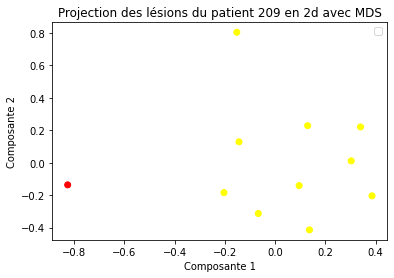

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs
la liste des clusters est : [[1, 2, 3, 4, 5, 6, 8, 9, 10], [7], [0]]
les index des VPC sont : [0]


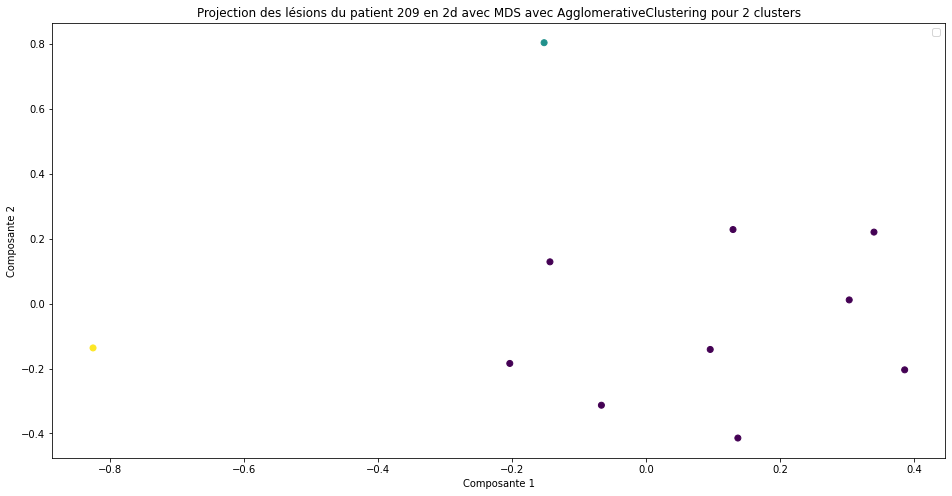

patient_id : 211 index : 215


No handles with labels found to put in legend.


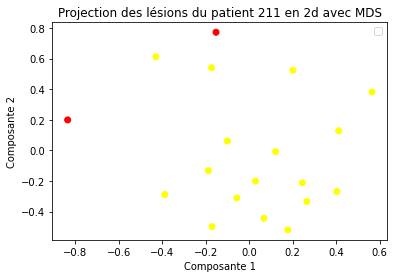

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 2 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 2 VPC sur 2 dont 0 faux positifs
la liste des clusters est : [[1, 3, 4, 7, 17], [2, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18], [0, 5]]
les index des VPC sont : [0, 5]


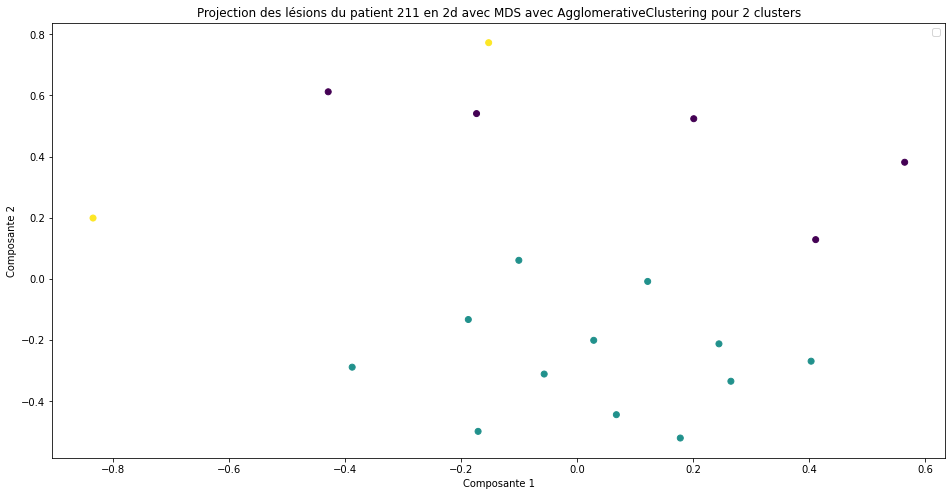

Pour les clusters uniques, rappel : 57.14285714285714 % précision : 61.53846153846154 % et f1 = 59.25925925925925
Pour les clusters uniques + petit cluster , rappel : 85.71428571428571 % précision : 15.384615384615385 % et f1 = 26.08695652173913
Pour les clusters uniques + petit cluster , spécificité : 88.65979381443299 % 


In [ ]:
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0 #nombre de lésions prédites comme des VPC dans un cluster unique ou dans des petits clusters
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0 #nombres d'images dans notre dataset
nb_testés_total=0 #initialisation des données statistiques

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv') #on lit notre dataset d'entrainement
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True) #et on l'index par l'identifiant du patient

patient_id=0
for index, row in patients_train_clustering_par_predicteurs.iterrows(): #à chaque ligne
  if patient_id!=index: #lorsqu'on change de patient
    print("patient_id : "+str(patient_id)+" index : "+str(index))
    patient_infos = patients_train_clustering_par_predicteurs.loc[index] #on récupère le patient qui nous interesse
    Y = DataFrame(patient_infos['concensus'], columns = ['concensus']) #on récupère le label de l'image pour faire de la visualisation
    X=patient_infos.drop(['image','concensus'],axis=1) #on récupère les features de notre images
    Y['concensus'][Y['concensus'] == 0] = "red"
    Y['concensus'][Y['concensus'] != "red"] = "yellow"
    y=[]
    for i ,row in Y.iterrows():
      y.append(row[0])  #on créer une liste de couleur ou la couleur rouge décrit les VPC et le jaune les autres 

    nb_images=nb_images+len(y)

    silhouette_vals=[]
    
    nb_cluster_minimum=3
    K = range(nb_cluster_minimum,6) #test de nb_cluster_minimum à 5 clusters
    for o in K:
      clustering = AgglomerativeClustering(n_clusters=o).fit(X)
      labels = clustering.labels_
      silhouette_vals.append(np.mean(silhouette_score(X,labels))) #pour un certains nombre de clusters on calcule la silhouette de notre clustering

    mds = manifold.MDS(n_components=2)
    mds.fit(X)
    projectedMDS = mds.fit_transform(X)
    plt.scatter(projectedMDS[:, 0], projectedMDS[:, 1], c=y)
    plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec MDS")
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.legend()
    plt.show() #on visualise les lésions cutanées du patient avec mds, les VPC y sont situés en rouge 

    idx_max=0
    max=-1
    for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette - nb_cluster_minimum
      if silhouette_vals[k]>max:
        max=silhouette_vals[k]
        idx_max=k

    clustering = AgglomerativeClustering(n_clusters=idx_max+nb_cluster_minimum)    #l'on utilise le nombre de clusters maximisant la silhouette
    prediction = clustering.fit_predict(X)

    #comparaison entre le vrai clustering et la prediction au niveau des VPC
    #premièrement on regarde le nombre de VPC repérés dans des clusters uniques

    index_VPC=[] #dans cette liste apparaitront les index des VPC
    nb_testés=0 #nombre de lésions prédites comme des VPC dans un cluster unique
    nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction

    liste_clusters=[] #dans cette liste apparaitront les index des images par cluster pour les repérer plus facilement an allant regarder nos images
    for e in range(nb_clusters):
      liste_clusters.append([])

    for a in range(len(y)):
      if y[a]=="red":
        index_VPC.append(a) #index des VPC
      liste_clusters[prediction[a]].append(a)
    
    clusters_unique=[]
    for g in range (nb_clusters):
      if len(liste_clusters[g])==1:
        nb_testés=nb_testés+1
        nb_testés_total=nb_testés_total+1
        clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
    nb_trouvés_unique=0
    for l in index_VPC:
      if l in clusters_unique:
        nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
    nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique #nombre total de VPC trouvés par clusters contenant un seul individu
    nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique #nombres total d'images apparaissant dans des clusters uniques sans être un VPC
  
    print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

    #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

    nb_VPC_total = nb_VPC_total + len(index_VPC)

    nb_trouvés_petit_cluster=0
    nb_cas_petit_cluster=0 #le nombre d'images que l'on va tester en regardant les petit clusters
    liste_index_petit_clusters=[]
    nb_individus_max=4

    for r in range(len(liste_clusters)):
      if 1<len(liste_clusters[r])<=nb_individus_max: #pour les clusters allant jusqu'à nb_individus_max individus on regarde s'il s'y trouve des VPC
        nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r]) 
        nb_testés=nb_testés+len(liste_clusters[r]) #le nombre d'images testés augmente et permet de voir les nombre de faux positifs pour un patient
        nb_testés_total=nb_testés_total+len(liste_clusters[r])
        liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
    for g in liste_index_petit_clusters:
      for h in liste_clusters[g]:
        if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
          nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

    nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster #le nombre de faux positifs trouvés dans les petits clusters se voit augmenter 
    nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster #le nombre de vrai positif dans les clusters uniques et petits clusters

    print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

    print("la liste des clusters est : "+str(liste_clusters))
    print("les index des VPC sont : "+str(index_VPC))

    plt.figure(figsize=(16,8))
    plt.scatter(projectedMDS[: , 0] , projectedMDS[: , 1] , c = prediction)
    plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec MDS avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.legend()
    plt.show() #cette fois on affiche la prediction du clustering jierarchique ayant le meilleur score en silhouette 

  patient_id=index #on change de patient
  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn = nb_VPC_total- vp
vn= nb_images -fp-vp-fn

print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")
